# CPLEX IMPLEMENTATION

## Imports

### 📦 Packages

In [42]:
import cplex
from cplex import Cplex

import os
import re
import numpy as np
import pandas as pd
import geopandas as gpd

import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [43]:
os.makedirs("2_Model", exist_ok=True)
model_dir="2_Model"
os.makedirs("3_Solution", exist_ok=True)
solution_dir="3_Solution"

## Prepare Inputs

### Define fixed sets: Time periods and Road widths

In [44]:
# Define fixed sets
T = tuple([1, 2, 3, 4, 5])  # 5 time periods
W = tuple(['timber','wide'])     # Road widths

### get component-dependent sets

In [45]:
# path to example comp
component_dir =r'1_Preprocessed_Data\4_Road_Network_Graphs\comp_4_11_12_13_51_merged'

### ● Load nodes

In [46]:
def load_nodes(component_dir, filename="4withsources_nodes.csv"):
    """
    Load nodes from CSV and return source nodes, exit nodes, and all node coordinates.

    Parameters:
        component_dir (str): Directory containing the nodes CSV.
        filename (str): Name of the nodes CSV file (default: '4withsources_nodes.csv').

    Returns:
        tuple:
            V_source (DataFrame): Subset of nodes_df where is_source == True
            V_exit (DataFrame): Subset of nodes_df where is_exit == True
            V (list): List of (x, y) tuples for all nodes
            nodes_df (DataFrame): Full nodes dataframe
    """
    file_path = f"{component_dir}\\{filename}"
    nodes_df = pd.read_csv(file_path)

    # filter nodes
    V_source = nodes_df[nodes_df["is_source"] == True]
    V_exit = nodes_df[nodes_df["is_exit"] == True]

    # all node coordinates
    V = list(zip(nodes_df["x"], nodes_df["y"]))

    return V_source, V_exit, V, nodes_df


In [47]:
# Example usage
V_source, V_exit, V, nodes_df = load_nodes(component_dir)

#### Map nodes to ID

In [48]:
def build_node_mappings(V, V_source, V_exit):
    """
    Build node ID mappings and extract node IDs for source and exit nodes.

    Parameters:
        V (list): List of (x, y) coordinates for all nodes.
        V_source (DataFrame): Source nodes (must have 'x' and 'y').
        V_exit (DataFrame): Exit nodes (must have 'x' and 'y').

    Returns:
        tuple:
            node_ID_mapping (dict): Mapping {'nodeX': (x, y)}.
            reversed_node_ID_mapping (dict): Mapping {(x, y): 'nodeX'}.
            V_nodeIDs (list): List of node IDs for all nodes.
            V_source_nIDs (list): List of node IDs for source nodes.
            V_exit_nIDs (list): List of node IDs for exit nodes.
    """
    # forward mapping: node name → coordinates
    node_ID_mapping = {f"node{i + 1}": V[i] for i in range(len(V))}

    # reverse mapping: coordinates → node name
    reversed_node_ID_mapping = {v: k for k, v in node_ID_mapping.items()}

    # all node IDs
    V_nodeIDs = [reversed_node_ID_mapping[v] for v in V]

    # source and exit node IDs
    V_source_nIDs = [reversed_node_ID_mapping[v] for v in zip(V_source["x"], V_source["y"])]
    V_exit_nIDs = [reversed_node_ID_mapping[v] for v in zip(V_exit["x"], V_exit["y"])]

    return node_ID_mapping, reversed_node_ID_mapping, V_nodeIDs, V_source_nIDs, V_exit_nIDs


In [49]:
# Example usage
node_ID_mapping, reversed_node_ID_mapping, V_nodeIDs, V_source_nIDs, V_exit_nIDs = build_node_mappings(V, V_source, V_exit)

### Transit nodes

In [50]:
def get_transit_nodes(V_nodeIDs, V_source_nIDs, V_exit_nIDs):
    """
    Compute the set of transit nodes (neither source nor exit).

    Parameters:
        V_nodeIDs (iterable): All node IDs in the graph.
        V_source_dict (dict): Mapping {stand_id: node_id} for source nodes.
        V_exit (iterable): Collection of exit node IDs.

    Returns:
        set: The set of transit node IDs.
    """
    V_transit = set(V_nodeIDs) - set(V_source_nIDs) - set(V_exit_nIDs)

    # Debug: print counts for verification
    print("Total nodes:", len(V_nodeIDs))
    print("Transit nodes:", len(V_transit))
    print("Source nodes:", len(V_source_nIDs))
    print("Exit nodes:", len(V_exit_nIDs))
    return V_transit

In [51]:
# example usage
V_transit = get_transit_nodes(V_nodeIDs, V_source_nIDs, V_exit_nIDs)

Total nodes: 334
Transit nodes: 122
Source nodes: 66
Exit nodes: 146


### Arcs & Edges

In [52]:
def load_and_verify_arcs(component_dir):
    # Load the arcs from the CSV files
    arcs_fw_df = pd.read_csv(f'{component_dir}/arcsforward.csv', header=0)
    arcs_bw_df = pd.read_csv(f'{component_dir}/arcsbackward.csv', header=0)
    arcs_df = pd.read_csv(f'{component_dir}/arcs.csv', header=0)
    edge_attr_df = pd.read_csv(f'{component_dir}/arcs_with_attributes.csv', header=0)

    # Assign the data to the respective variable
    A = arcs_df.values

    # Print lengths
    print(f"Total arcs: {len(A)}, Forward arcs: {len(arcs_fw_df)}, Backward arcs: {len(arcs_bw_df)}")

    # Check if number of forward arcs equals number of backward arcs
    if len(arcs_fw_df) != len(arcs_bw_df):
        print("Warning: Number of forward arcs is NOT equal to number of backward arcs!")

    # Check if forward arcs are the reverse of backward arcs
    fw_arcs = arcs_fw_df.values
    bw_arcs = arcs_bw_df.values

    if len(fw_arcs) == len(bw_arcs):
        reversed_bw = np.flip(bw_arcs, axis=1)  # Reverse each arc [to, from] -> [from, to]
        if np.array_equal(fw_arcs, reversed_bw):
            print("✅ Forward arcs are the reverse of backward arcs.")
        else:
            print("❌ Forward arcs are NOT the reverse of backward arcs.")
    else:
        print("Cannot check reverse relationship due to different lengths.")

    return A, arcs_fw_df, arcs_bw_df, edge_attr_df


In [53]:
#example usage
A, arcs_fw, arcs_bw, edge_attr_df = load_and_verify_arcs(component_dir)

Total arcs: 1752, Forward arcs: 876, Backward arcs: 876
✅ Forward arcs are the reverse of backward arcs.


#### use nodes IDs in arcs

In [54]:
# Function to map coordinates to short names
def map_coordinates_to_nodeIDs(coords):
    try:
        coords_tuple = tuple(map(float, coords.strip('()').split(', ')))
    except:
        return None  # handle invalid format
    for nodeID, node_coords in node_ID_mapping.items():
        if coords_tuple == node_coords:
            return nodeID
    return None  # Return None if the coordinates are not found

def replace_coord_with_IDs(A, arcs_fw, arcs_bw):
    # Replace coordinates with their short names
    A = [[map_coordinates_to_nodeIDs(pair[0]), map_coordinates_to_nodeIDs(pair[1])] for pair in A]
    A_fw = [[map_coordinates_to_nodeIDs(pair[0]), map_coordinates_to_nodeIDs(pair[1])] 
            for pair in arcs_fw.values]
    A_bw = [[map_coordinates_to_nodeIDs(pair[0]), map_coordinates_to_nodeIDs(pair[1])] 
            for pair in arcs_bw.values]
    return A, A_fw, A_bw

In [55]:
# example
A, A_fw, A_bw = replace_coord_with_IDs(A, arcs_fw, arcs_bw)

In [56]:
def process_edge_pairs(A, A_fw, A_bw, verify=True):
    """
    Convert edge pairs into string tuples and verify forward/backward split.

    Parameters:
        A (iterable): Original collection of edge pairs (tuples/lists of chars/strings).
        A_fw (iterable): Forward edge pairs.
        A_bw (iterable): Backward edge pairs.
        verify (bool): If True, checks that A == A_fw ∪ A_bw.

    Returns:
        dict: Dictionary with transformed tuples and verification result.
    """
    # Convert each set of pairs into tuple of concatenated strings
    A = tuple("".join(pair) for pair in A)
    A_fw = tuple("".join(pair) for pair in A_fw)
    A_bw = tuple("".join(pair) for pair in A_bw)
    E = A_fw  # alias for forward edges

    result = {
        "A": A,
        "A_fw": A_fw,
        "A_bw": A_bw,
        "E": E,
        "sample_fw": A_fw[1] if len(A_fw) > 1 else None,
    }

    # Optional verification
    if verify:
        result["verified"] = (set(A) == set(A_fw) | set(A_bw))

    return A, A_fw, A_bw, E

In [57]:
# example usage
A, A_fw, A_bw, E = process_edge_pairs(A, A_fw, A_bw)

### [helper functions] swap halves and split edge into nodes

In [58]:
# Helper function to swap halves
def swap_direction(arc):
    """
    Swap direction of an arc.
    If arc is a tuple/list (u, v), return (v, u).
    If arc is a string like 'node1node2', split it.
    """
    if isinstance(arc, (tuple, list)) and len(arc) == 2:
        return (arc[1], arc[0])
    elif isinstance(arc, str):
        mid = arc.find('node', 4)  
        return arc[mid:] + arc[:mid] 
    else:
        raise ValueError(f"Unsupported arc format: {arc}")

def split_edge_to_nodes(edge):
    if isinstance(edge, str):
        mid = edge.find('node', 4)  # guaranteed to exist
        return [edge[:mid], edge[mid:]]
    else:
        raise TypeError("Input must be a string.")


In [59]:
def create_forward_backward_mapping(A_fw, A_bw, swap_direction):
    """
    Creates a mapping between forward arcs and backward arcs using a swap function.

    Parameters:
    - A_fw: iterable of forward arcs
    - A_bw: iterable of backward arcs
    - swap_direction: function that takes an arc and returns its swapped version

    Returns:
    - fw_to_bw_map: dict mapping forward arcs to backward arcs
    - bw_to_fw_map: dict mapping backward arcs to forward arcs
    """
    fw_to_bw_map = {}
    for arc in A_fw:
        swapped = swap_direction(arc)
        if swapped in A_bw:
            fw_to_bw_map[arc] = swapped

    bw_to_fw_map = {v: k for k, v in fw_to_bw_map.items()}
    return fw_to_bw_map, bw_to_fw_map

In [60]:
# example usage
fw_to_bw, bw_to_fw = create_forward_backward_mapping(A_fw, A_bw, swap_direction)

### dict to map StandID: SourceNodeID

In [61]:
def build_source_dict(source_nodes, reversed_node_ID_mapping):
    """
    Build a dictionary mapping stands -> node IDs using source node coordinates.

    Parameters:
        source_nodes (pd.DataFrame): DataFrame with at least 'stands', 'x', 'y' columns.
        reversed_node_ID_mapping (dict): Mapping from (x, y) -> node ID.

    Returns:
        tuple:
            V_source_dict (dict): Mapping {stand_id: node_id}.
            S (set): Set of stand IDs.
    """
    # Initial mapping: stand -> (x, y)
    V_source_dict = {
        int(row['stands']): (row['x'], row['y'])
        for _, row in source_nodes.iterrows()
    }

    # Replace coordinates with node IDs
    for key, node in V_source_dict.items():
        V_source_dict[key] = reversed_node_ID_mapping[node]

    # Define S = stands in V_source
    S = set(V_source_dict.keys())

    return V_source_dict, S

In [62]:
# example usage
V_source_dict, S = build_source_dict(V_source, reversed_node_ID_mapping)

### Source arcs

In [63]:
def get_source_arcs(A, V_source_dict):
    """
    Collect arcs that go into source nodes and out of them.

    Parameters:
        A (iterable): List of arcs, each as a list [u, v] or tuple (u, v).
        V_source_dict (dict): Mapping {stand_id: node_id}.

    Returns:
        dict: {stand_id: set of arcs (ingoing to source)}
        dict: same as above for outgoing
    """
    source_arcs_ingoing = {}
    source_arcs_outgoing = {}

    for standID, sourcenode in V_source_dict.items():
        ingoing = set()
        outgoing = set()
        for arc in A:
            u, v = split_edge_to_nodes(arc)  # unpack list or tuple
            if v == sourcenode:   # incoming arc if target matches source node
                ingoing.add(arc)
            elif u == sourcenode:   # outgoing arc if source matches
                outgoing.add(arc)
        source_arcs_ingoing[standID] = ingoing
        source_arcs_outgoing[standID] = outgoing

    total_in_arcs = sum(len(v) for v in source_arcs_ingoing.values())
    print(total_in_arcs, "ingoing to source nodes in total")

    total_out_arcs = sum(len(v) for v in source_arcs_outgoing.values())
    print(total_out_arcs, "outgoing from source nodes in total")

    return source_arcs_ingoing, source_arcs_outgoing

In [64]:
# example usage
source_arcs_ingoing, source_arcs_outgoing = get_source_arcs(A, V_source_dict)

538 ingoing to source nodes in total
538 outgoing from source nodes in total


### Exit arcs

In [65]:
def build_exit_arcs(V_exit_nodeIDs, A):
    """
    Build dictionaries of outgoing and ingoing arcs for each exit node.
    """
    exit_arcs_ingoing = {}
    exit_arcs_outgoing = {}

    for exitnode in V_exit_nodeIDs:
        ingoing = set()
        outgoing = set()
        for arc in A:
            u, v = split_edge_to_nodes(arc)  # unpack arc from string
            if u == exitnode:
                outgoing.add(arc)
            if v == exitnode:
                ingoing.add(arc)
        # assign sets to dictionaries
        exit_arcs_ingoing[exitnode] = ingoing
        exit_arcs_outgoing[exitnode] = outgoing

    total_in_arcs = sum(len(v) for v in exit_arcs_ingoing.values())
    total_out_arcs = sum(len(v) for v in exit_arcs_outgoing.values())
    return exit_arcs_ingoing, total_in_arcs, exit_arcs_outgoing, total_out_arcs

In [66]:
# example usage
exit_arcs_ingoing, totalin, exit_arcs_outgoing, totalout = build_exit_arcs(V_exit_nIDs, A)
print(totalin, "ingoing arcs to exit nodes")
print(totalout, "outgoing arcs from exit nodes")

541 ingoing arcs to exit nodes
541 outgoing arcs from exit nodes


### Transit arcs

In [67]:
def build_transitnode_arcs(V_transit, A):
    """
    Build ingoing/outgoing arc dictionaries for transit nodes,
    where arcs are strings like 'node1node245'.
    
    Parameters:
        V_transit (iterable): Transit node IDs, e.g., ['node5', 'node8', ...]
        A (iterable): Arcs as strings, e.g., 'node1node245'
    
    Returns:
        tuple: (ingoing_per_transitnode, outgoing_per_transitnode, total_ingoing, total_outgoing)
    """
    ingoing_per_transitnode = {}
    outgoing_per_transitnode = {}

    for tnode in V_transit:
        ingoing = {arc for arc in A if split_edge_to_nodes(arc)[1] == tnode}
        outgoing = {arc for arc in A if split_edge_to_nodes(arc)[0] == tnode}
        ingoing_per_transitnode[tnode] = ingoing
        outgoing_per_transitnode[tnode] = outgoing

    total_ingoing = sum(len(v) for v in ingoing_per_transitnode.values())
    total_outgoing = sum(len(v) for v in outgoing_per_transitnode.values())

    return ingoing_per_transitnode, outgoing_per_transitnode, total_ingoing, total_outgoing

In [68]:
# example usage
ingoing_per_transitnode, outgoing_per_transitnode, total_in, total_out = build_transitnode_arcs(V_transit, A)

## Load parameters and actual values

### 💰 Load Costs

In [69]:
def load_and_process_edge_attributes(csv_path, reverse_mapping):
    """
    Load edge attribute CSV and create EdgeID using node reverse mapping.

    Parameters:
        csv_path (str): Path to the CSV file containing edge attributes.
        reverse_mapping (dict): Mapping from (x, y) coordinates to node IDs.

    Returns:
        pd.DataFrame: Edge attribute DataFrame with added 'node1_ID', 'node2_ID', and 'EdgeID' columns.
    """
    # Load CSV
    edge_attr_df = pd.read_csv(csv_path)

    # Map Node1 and Node2 coordinates to node IDs
    edge_attr_df['node1_ID'] = edge_attr_df['Source(x,y)'].map(reverse_mapping)
    edge_attr_df['node2_ID'] = edge_attr_df['Target(x,y)'].map(reverse_mapping)

    # Ensure both are strings and create EdgeID
    edge_attr_df['EdgeID'] = edge_attr_df['node1_ID'].astype(str) + edge_attr_df['node2_ID'].astype(str)

    return edge_attr_df


In [70]:
# example usage
edge_attr_df = load_and_process_edge_attributes(f'{component_dir}/arcs_with_attributes.csv', reverse_mapping)

### Set costs parameters

In [71]:
def build_cost_dicts(E, W, edge_attr_df):
    """
    Build cost dictionaries for construction, maintenance, and upgrade.

    Parameters:
        E (iterable): Collection of edge IDs.
        W (list/tuple): List of weight categories (e.g., [5, 10]).
        edge_attr_df (pd.DataFrame): DataFrame with columns:
            'EdgeID', 'Build5m', 'Build10m', 'Maintain5m', 'Maintain10m', 'Upgrade'.

    Returns:
        tuple:
            CostC (dict): {(edge, weight): construction cost}.
            CostM (dict): {(edge, weight): maintenance cost}.
            CostU (dict): {edge: upgrade cost}.
    """
    # Initialize dictionaries
    CostC = {(e, w): None for e in E for w in W}
    CostM = {(e, w): None for e in E for w in W}
    CostU = {e: None for e in E}

    # prepare the edge attributed df
    edge_attr_df['node1_ID'] = edge_attr_df['Source(x,y)'].map(reverse_mapping)
    edge_attr_df['node2_ID'] = edge_attr_df['Target(x,y)'].map(reverse_mapping)
    edge_attr_df['EdgeID'] = edge_attr_df['node1_ID'].astype(str) + edge_attr_df['node2_ID'].astype(str)

    # Assign actual cost values from DataFrame
    for _, row in edge_attr_df.iterrows():
        e = row['EdgeID']

        CostC[(e, W[0])] = round(row['Build5m'], 2)
        CostC[(e, W[1])] = round(row['Build10m'], 2)

        CostM[(e, W[0])] = round(row['Maintain5m'], 2)
        CostM[(e, W[1])] = round(row['Maintain10m'], 2)

        CostU[e] = round(row['Upgrade'], 2)

    return CostC, CostM, CostU

In [72]:
# example usage
CostC, CostM, CostU = build_cost_dicts(E, W, edge_attr_df)

### Load Access Needs

In [73]:
# stakeholder solution as example
stakepath = r'1_Preprocessed_Data\2_Stands_Access_Requirements\stake_stands_access_needs.csv'

In [74]:
def load_access_needs(csv_path, filter_stands=None, split_columns=True, n_split=5):
    """
    Load a stands access needs CSV, set 'ID_UG' as the index, optionally filter by a set of stand IDs,
    modify column names to integers, and optionally split into two parts.

    Parameters:
        csv_path (str): Path to the CSV file.
        filter_stands (set, optional): Set of stand IDs (ID_UG) to keep. Defaults to None.
        split_columns (bool, optional): Whether to split the dataframe into two parts. Defaults to True.
        n_split (int, optional): Number of columns for the split. Defaults to 5.

    Returns:
        tuple: (df1, df2) if split_columns is True, else df
            - df1: First n_split columns (original)
            - df2: Last n_split columns (wide/extended)
    """
    # Load CSV and set index
    df = pd.read_csv(csv_path)
    df.set_index('ID_UG', inplace=True)

    # Filter for given stand IDs
    if filter_stands is not None:
        df = df[df.index.isin(filter_stands)]

    # Modify column names to integers based on suffix after '_'
    df.columns = df.columns.str.split('_').str[-1].astype(int)

    # Optionally split into two parts
    if split_columns:
        df1 = df.iloc[:, :n_split]  # First n_split columns
        df2 = df.iloc[:, -n_split:]  # Last n_split columns
        return df1, df2

    return df

In [75]:
# example usage
accessneeds_df, wide_accessneeds_df = load_access_needs(stakepath, filter_stands=S)
print(f"timber access needs columns:")
print(accessneeds_df.head(1))
print(f"wide access needs columns:")
print(wide_accessneeds_df.head(1))

timber access needs columns:
       1  2  3  4  5
ID_UG               
1199   1  1  1  1  1
wide access needs columns:
       1  2  3  4  5
ID_UG               
1199   0  0  0  0  0


### Set needroad parameters, for all stands ID in S
$$needroad_{s,t}^\text{timber}$$

$$needroad_{s,t}^\text{wide}$$

In [76]:
def set_needroad_parameters(S, T, accessneeds_df_dict):
    """
    Create a dictionary of need road parameters for different access types.

    Parameters:
        S (iterable): Source nodes.
        T (iterable): Target nodes.
        accessneeds_df_dict (dict): Mapping {access_type: DataFrame} with needs from sources to targets.

    Returns:
        dict: Dictionary with keys (access_type, s, t) and corresponding need values.
    """
    needroad = {}
    for access_type, df in accessneeds_df_dict.items():
        for s in S:
            for t in T:
                needroad[(access_type, s, t)] = df.loc[s, t] if s in df.index else 0
    return needroad

In [77]:
# Example usage
accessneeds_df_dict = {
    'timber': accessneeds_df,
    'wide': wide_accessneeds_df
}

needroad_w_s_t = set_needroad_parameters(S, T, accessneeds_df_dict)

### Calculate maxflow parameters
$$maxflow_t^\text{timber} = \sum_{s\in S}needroad_{s,t}^\text{timber}$$

In [78]:
def set_maxflow_params(S, T, needroad_w_s_t, access_types):
    """
    Create maxflow dictionaries for given access types.

    Parameters:
        S (iterable): Source nodes.
        T (iterable): Target nodes.
        needroad_w_s_t (dict): Dictionary {(access_type, s, t): need}.
        access_types (list): List of access types to compute ('timber', 'wide', etc.).

    Returns:
        dict: Dictionary of maxflow dicts for each access type, e.g.,
              {'timber': maxflow_timber_dict, 'wide': maxflow_wide_dict}
    """
    maxflow_dicts = {}
    
    for w in access_types:
        maxflow = {
            (w, t): sum(needroad_w_s_t[(w, s, t)] for s in S for t in T)
            for t in T
        }
        maxflow_dicts[w] = maxflow
    
    return maxflow_dicts

In [79]:
# Example usage
access_types = ['timber', 'wide']
maxflow_results = set_maxflow_params(S, T, needroad_w_s_t, access_types)

maxflow_timber = maxflow_results['timber']
maxflow_wide = maxflow_results['wide']

# Combine both dictionaries
maxflow_w_t = {**maxflow_timber, **maxflow_wide}

maxflow_w_t

{('timber', 1): 159,
 ('timber', 2): 159,
 ('timber', 3): 159,
 ('timber', 4): 159,
 ('timber', 5): 159,
 ('wide', 1): 1,
 ('wide', 2): 1,
 ('wide', 3): 1,
 ('wide', 4): 1,
 ('wide', 5): 1}

$$maxflow_t^\text{wide} = \sum_{s\in S}needroad_{s,t}^\text{wide}$$

## Define binary decision variables

### define binary variables for construction maintenance upgrade

In [80]:
def create_binary_decision_variables(E, W, T):
    """
    Create dictionaries of binary decision variable names for construction, maintenance, and upgrade.

    Parameters:
        E (iterable): Edge IDs.
        W (iterable): Weight categories (e.g., [5, 10]).
        T (iterable): Time steps (integers).

    Returns:
        tuple:
            C (dict): {(edge, weight, t): variable_name} for construction.
            M (dict): {(edge, weight, t): variable_name} for maintenance.
            U (dict): {(edge, t): variable_name} for upgrade.
    """
    C = {(e, w, t): f"C_{w}_{e}_t{t}" for e in E for w in W for t in (0,) + tuple(T)}
    M = {(e, w, t): f"M_{w}_{e}_t{t}" for e in E for w in W for t in (0,) + tuple(T)}
    U = {(e, t): f"U_{e}_t{t}" for e in E for t in (0,) + tuple(T)}

    print("Decision variables for C, M, U created.")
    return C, M, U


In [81]:
# example usage Create binary decision variables
C, M, U = create_binary_decision_variables(E, W, T)

Decision variables for C, M, U created.


### verify the created decision variables

In [82]:
def verify_binary_variables(E, T, C, M, U):
    """
    Simple verification of binary decision variables sizes.

    Parameters:
        E (iterable): List of edge IDs.
        T (iterable): Time steps.
        C (dict): Construction variables.
        M (dict): Maintenance variables.
        U (dict): Upgrade variables.
    """
    expected_U = len(E) * (len(T) + 1)
    expected_CM = expected_U * 2

    print(f"U: {len(U)} / expected {expected_U}")
    print(f"C: {len(C)} / expected {expected_CM}")
    print(f"M: {len(M)} / expected {expected_CM}")

    if len(U) == expected_U and len(C) == expected_CM and len(M) == expected_CM:
        print("✅ All variable counts are correct")
    else:
        print("❌ Variable counts mismatch")


In [83]:
# example Verify
verify_binary_variables(E, T, C, M, U)

U: 5256 / expected 5256
C: 10512 / expected 10512
M: 10512 / expected 10512
✅ All variable counts are correct


## Define integer variables for flow

In [84]:
def create_integer_flow_variables(A, W, T):
    """
    Create dictionary of integer flow variable names.

    Parameters:
        A (iterable): List of arcs.
        W (iterable): Weight categories.
        T (iterable): Time steps.

    Returns:
        dict: {(arc, weight, t): variable_name}
    """
    flow = {(a, w, t): f"flow_{w}_{a}_t{t}" for a in A for w in W for t in T}
    return flow

In [85]:
# example usage
flow = create_integer_flow_variables(A, W, T)

## Build model

In [86]:
# path for storage 
model_dir = "2_Model"

In [87]:
# Initialize the CPLEX model
model = Cplex()
model.set_problem_type(Cplex.problem_type.LP)

# make sure all is clean before adding variables
model.variables.delete()

### Add binary decision variables

In [88]:
def add_binary_variables_to_model(model, C, M, U, CostC, CostM, CostU):
    """
    Add binary decision variables (C, M, U) to a CPLEX model and prepare objective terms and coefficients.

    Parameters:
        model: CPLEX model object.
        C, M, U (dict): Binary variable dictionaries {(edge, weight, t) or (edge, t): name}.
        CostC, CostM, CostU (dict): Cost dictionaries corresponding to the variables.

    Returns:
        tuple: (objective_terms, objective_coeffs)
            - objective_terms: list of variable names
            - objective_coeffs: list of corresponding cost coefficients
    """
    objective_terms = []
    objective_coeffs = []

    # Add C_vars
    for (e, w, t), name in C.items():
        lb, ub = (0, 0) if t == 0 else (0, 1)
        model.variables.add(names=[name], lb=[lb], ub=[ub], types=["B"])
        objective_terms.append(name)
        objective_coeffs.append(CostC[(e, w)])

    # Add M_vars
    for (e, w, t), name in M.items():
        lb, ub = (0, 0) if t == 0 else (0, 1)
        model.variables.add(names=[name], lb=[lb], ub=[ub], types=["B"])
        objective_terms.append(name)
        objective_coeffs.append(CostM[(e, w)])

    # Add U_vars
    for (e, t), name in U.items():
        lb, ub = (0, 0) if t == 0 else (0, 1)
        model.variables.add(names=[name], lb=[lb], ub=[ub], types=["B"])
        objective_terms.append(name)
        objective_coeffs.append(CostU[e])
    
    print("Decision variables for C, M, U added to model.")

    return objective_terms, objective_coeffs

In [89]:
# example usage
objective_terms, objective_coeffs = add_binary_variables_to_model(
    model, C, M, U, CostC, CostM, CostU
)

Decision variables for C, M, U added to model.


#### verify & store
should be len(E) x (len (T)+1) x 5
because 5 different actions

In [90]:
def verify_action_variables(model, E, T, objective_coeffs, n_actions=5):
    """
    Verify that the number of action variables and objective coefficients is correct.

    Parameters:
        model: CPLEX model object.
        E (iterable): List of edges.
        T (iterable): List of time steps.
        objective_coeffs (list): List of objective function coefficients.
        n_actions (int): Number of different actions per edge-time (default 5).

    Prints:
        Verification messages for variable count and objective coefficients.
    """
    n_action_variables = len(model.variables.get_names())
    expected_vars = len(E) * (len(T)+1) * n_actions

    print(n_action_variables, "action variables")
    print(f"{n_actions}*len(E)*(len(T)+1) =", expected_vars)
    print(len(objective_coeffs), "objective coefficients")

    if n_action_variables == expected_vars and len(objective_coeffs) == expected_vars:
        print("✅ Verification passed: variable and coefficient counts match expected")
    else:
        print("❌ Verification failed: counts do not match expected")

    return n_action_variables

In [91]:
# example usage
n_action_variables = verify_action_variables(model, E, T, objective_coeffs)

26280 action variables
5*len(E)*(len(T)+1) = 26280
26280 objective coefficients
✅ Verification passed: variable and coefficient counts match expected


In [92]:
def save_binary_variables_info(model, CostC, CostM, CostU, model_dir):
    """
    Save information about binary decision variables to a text file.

    Parameters:
        model: CPLEX model object.
        CostC, CostM, CostU (dict): Cost dictionaries for construction, maintenance, and upgrade.
        model_dir (str): Directory where the file will be saved.
    """
    os.makedirs(model_dir, exist_ok=True)
    file_path = os.path.join(model_dir, "binary_decision_variables.txt")

    with open(file_path, "w") as f:
        var_names = model.variables.get_names()
        for name in var_names:
            lb = model.variables.get_lower_bounds([name])[0]
            ub = model.variables.get_upper_bounds([name])[0]
            var_type = model.variables.get_types([name])[0]

            # Determine edge/arc and weight
            e_match = re.search(r"node[\w]+(?=_t\d+)", name)
            e = e_match.group(0) if e_match else "N/A"

            if name[0] != "U":
                w_match = re.search(r"[CMU]_(\w+)(?=_node)", name)
                w = w_match.group(1) if w_match else "N/A"
                if name[0] == "C":
                    cost_coeff = CostC.get((e, w), "N/A")
                else:
                    cost_coeff = CostM.get((e, w), "N/A")
            else:
                cost_coeff = CostU.get(e, "N/A")

            f.write(f"{name}: lb={lb}, ub={ub}, type={var_type}, cost={cost_coeff}\n")

    print(f"Binary variable info saved to {file_path}")

In [93]:
# example usage
save_binary_variables_info(model, CostC, CostM, CostU, model_dir)

Binary variable info saved to 2_Model\binary_decision_variables.txt


In [94]:
def create_objective_dataframe(objective_terms, objective_coeffs):
    """
    Create a pandas DataFrame with variable names and corresponding objective costs.

    Parameters:
        objective_terms (list): List of variable names.
        objective_coeffs (list): Corresponding cost coefficients.

    Returns:
        pd.DataFrame: DataFrame with columns ['variable name', 'Cost'].
    """
    obj_df = pd.DataFrame({
        'variable name': objective_terms,
        'Cost': objective_coeffs
    })
    return obj_df


In [95]:
# example usage
obj_df = create_objective_dataframe(objective_terms, objective_coeffs)
obj_df.head(1)

,variable name,Cost
0,C_timber_node1node245_t0,None


### Objective Function

In [96]:
def set_objective(model, objective_terms, objective_coeffs):

    # Assign linear objective
    model.objective.set_linear(list(zip(objective_terms, objective_coeffs)))

    model.objective.set_sense(model.objective.sense.minimize) 
    # Confirm action
    print(f"Linear objective function assigned and set to minimize.")
   

In [97]:
# example usage
set_objective(model, objective_terms, objective_coeffs)

TypeError: non-float value in input sequence (None)

#### store objective function

In [ ]:
def save_objective_function_to_file(model, file_path):
    """
    Save the linear objective function of a CPLEX model to a text file.

    Parameters:
        model: CPLEX model object.
        file_path (str): Full path to the text file where the objective will be saved.
    """
    os.makedirs(os.path.dirname(file_path), exist_ok=True)

    objective_expr = model.objective.get_linear()
    
    with open(file_path, "w") as f:
        for i, coeff in enumerate(objective_expr):
            var_name = model.variables.get_names(i)
            f.write(f"{coeff} * {var_name}\n")
    
    print(f"Objective function saved to {file_path}")

In [ ]:
# example
save_objective_function_to_file(model, f"{model_dir}/objective_function.txt")

### Add flow variables

In [ ]:
def add_flow_variables(model, flow, lb=0, ub=9):
    """
    Add integer flow variables to a CPLEX model.

    Parameters:
        model: CPLEX model object.
        flow (dict): Dictionary of flow variables {(arc, weight, t): name}.
        lb (int, optional): Lower bound for variables. Default is 0.
        ub (int, optional): Upper bound for variables. Default is 9.
    """
    for (e, w, t), name in flow.items():
        model.variables.add(names=[name], lb=[lb], ub=[ub], types=["I"])
    
    print(f"{len(flow)} flow variables added to the model.")


In [ ]:
# example usage
flow = create_integer_flow_variables(A, W, T)  # Using your flow variable function
add_flow_variables(model, flow, lb=0, ub=9)

##### verify adding of flow variables
should be 2 x len(E) x len(T) variables

In [ ]:
def verify_flow_variables(model, n_action_variables, A, W, T):
    """
    Verify the number of flow variables in a CPLEX model.

    Parameters:
        model: CPLEX model object.
        n_action_variables (int): Number of previously added action variables.
        A (iterable): List of arcs.
        W (iterable): List of weight categories.
        T (iterable): List of time steps.
    """
    n_variables = len(model.variables.get_names())
    n_flow_variables = n_variables - n_action_variables
    expected_flow_variables = len(A) * len(T) * len(W)

    print(n_variables, "total variables")
    print(n_flow_variables, "flow variables")
    print(f"Expected flow variables (len(A)*len(T)*len(W)) = {expected_flow_variables}")

    if n_flow_variables == expected_flow_variables:
        print("✅ Flow variable count matches expected")
    else:
        print("❌ Flow variable count does NOT match expected")

    return n_flow_variables

def save_flow_variables_info(model, n_flow_variables, file_path):
    """
    Save information about flow variables to a text file.

    Parameters:
        model: CPLEX model object.
        n_flow_variables (int): Number of flow variables to consider (from the end of variable list).
        file_path (str): Full path to the output text file.
    """
    os.makedirs(os.path.dirname(file_path), exist_ok=True)

    var_names = model.variables.get_names()[-n_flow_variables:]

    with open(file_path, "w") as f:
        for name in var_names:
            lb = model.variables.get_lower_bounds([name])[0]
            ub = model.variables.get_upper_bounds([name])[0]
            var_type = model.variables.get_types([name])[0]
            f.write(f"{name}: lb={lb}, ub={ub}, type={var_type}\n")

    print(f"Flow variable info saved to {file_path}")


In [ ]:
# example usage
n_flow_variables = verify_flow_variables(model, n_action_variables, A, W, T)
save_flow_variables_info(model, n_flow_variables, f"{model_dir}/integer_flow_variables.txt")

In [ ]:
def verify_transitnode_arcs(flow, ingoing_per_transitnode, outgoing_per_transitnode, verbose=True):
    """
    Verifies that all arcs referenced in ingoing/outgoing transit nodes exist in the flow variables.

    Parameters
    ----------
    flow : dict
        Dictionary of flow variables indexed by (arc, road_type, period).
    ingoing_per_transitnode : dict
        Dictionary mapping transit nodes to lists of ingoing arcs.
    outgoing_per_transitnode : dict
        Dictionary mapping transit nodes to lists of outgoing arcs.
    verbose : bool, default True
        Whether to print detailed results.

    Returns
    -------
    dict
        Dictionary containing sets of missing arcs: {'missing_in': set, 'missing_out': set}
    """
    # Set of all arcs in the flow variables
    A_for_flow = {a for (a, _, _) in flow.keys()}

    # Find missing arcs
    missing_in_arcs = {
        a for arcs in ingoing_per_transitnode.values() 
        for a in arcs 
        if a not in A_for_flow
    }
    missing_out_arcs = {
        a for arcs in outgoing_per_transitnode.values() 
        for a in arcs 
        if a not in A_for_flow
    }

    if verbose:
        print("\n=== Transit Node Arc Verification ===")
        print(f"Missing arcs in ingoing per transit node: {len(missing_in_arcs)}")
        if missing_in_arcs:
            print(sorted(missing_in_arcs))
        print(f"Missing arcs in outgoing per transit node: {len(missing_out_arcs)}")
        if missing_out_arcs:
            print(sorted(missing_out_arcs))

        if not missing_in_arcs and not missing_out_arcs:
            print("✅ All transit node arcs are properly represented in the flow variables.")
        else:
            print("⚠️ Some arcs are missing. See above.")

    return {"missing_in": missing_in_arcs, "missing_out": missing_out_arcs}


In [ ]:
# example
arc_check_results = verify_transitnode_arcs(flow, ingoing_per_transitnode, outgoing_per_transitnode)

## Add Constraints

In [ ]:
# init
model.linear_constraints.delete()

### Flow (wide) enforces road existence (wide)

$$\forall t \in T \quad \forall e\in E: \qquad
flow_{(u,v),t}^{\text{wide}} + flow_{(v,u),t}^{\text{wide}}  \leq maxflow_t^{\text{wide}} \big(C _{e,t}^{\text{wide}} + M_{e,t}^{\text{wide}} +  U_{e,t}\big)$$
$$\Leftrightarrow$$
$$flow_{(u,v),t}^{\text{wide}} + flow_{(v,u),t}^{\text{wide}} - maxflow_t^{\text{wide}} \big(C _{e,t}^{\text{wide}} + M_{e,t}^{\text{wide}} +  U_{e,t}\big)  \leq 0$$
$$\Leftrightarrow$$
$$
flow_{(u,v),t}^{\text{wide}} + flow_{(v,u),t}^{\text{wide}} - maxflow_t^{\text{wide}}C _{e,t}^{\text{wide}} - maxflow_t^{\text{wide}}M_{e,t}^{\text{wide}} - maxflow_t^{\text{wide}}U_{e,t} \leq 0\\
$$

In [ ]:
def add_wide_flow_constraints(model, flow, C, M, U, maxflow_w_t, fw_to_bw_map, T, A_fw, road_type='wide', verification_log=None):
    """
    Adds constraints to enforce that flow only occurs on wide roads and optionally logs verification data.

    Prints a single checkmark when all constraints are added.
    """
    if verification_log is None:
        verification_log = []

    for t in T:
        for a_fw in A_fw:
            a_bw = fw_to_bw_map[a_fw]
            e = a_fw
            try:
                expr_vars = [flow[(a_fw, road_type, t)],
                             flow[(a_bw, road_type, t)],
                             C[(e, road_type, t)],
                             M[(e, road_type, t)],
                             U[(e, t)]]
                
                coeff = int(maxflow_w_t[(road_type, t)])
                expr_coeffs = [1, 1, -coeff, -coeff, -coeff]
                
                constraint_name = f"Constraint_flow_enforcing_road_{road_type}_{e}_{t}"
                
                # Add constraint
                model.linear_constraints.add(
                    lin_expr=[[expr_vars, expr_coeffs]],
                    senses=["L"],
                    rhs=[0],
                    names=[constraint_name]
                )
                
                # Store verification data
                verification_log.append({
                    "constraint_name": constraint_name,
                    "variables": expr_vars,
                    "coefficients": expr_coeffs
                })
                
            except KeyError as ke:
                verification_log.append({
                    "constraint_name": f"Missing_{road_type}_{e}_{t}",
                    "error": str(ke)
                })
                print("problem")

    # Single confirmation after all constraints are added
    print("Done.")
    return verification_log

verification_data = add_wide_flow_constraints(
    model, flow, C, M, U, maxflow_w_t, fw_to_bw_map, T, A_fw
)

Done.


### [helper function] verify and store constraints

In [ ]:
def verify_and_store_constraints(model, verification_data, group_name, expected_count, output_file):
    """
    Verify constraints for a specific group, and store them in a file.

    Parameters:
        model: CPLEX model object.
        verification_data (list of dict): Log of constraints, each with "constraint_name".
        group_name (str): Identifier substring for the constraint group.
        expected_count (int): Expected number of constraints in this group.
        output_file (str): Path to store constraints belonging to this group.

    Returns:
        bool: True if the check passed, False otherwise.
    """
    # Count total constraints in the model
    total_constraints = model.linear_constraints.get_num()

    # Filter constraints of this group
    group_constraints = [
        v for v in verification_data
        if group_name in v.get("constraint_name", "")
    ]
    n_constraints_group = len(group_constraints)

    # --- Report ---
    print(f"\n=== Constraint Verification: {group_name} ===")
    print(f"Total constraints in model: {total_constraints}")
    print(f"Constraints added in this group: {n_constraints_group}")
    print(f"Expected number of constraints for this group: {expected_count}")

    if n_constraints_group == expected_count:
        print(f"✅ Check passed: {n_constraints_group} constraints added as expected.")
        status = True
    else:
        print(f"❌ Check failed: {n_constraints_group} constraints added, expected {expected_count}.")
        status = False

    # --- Store constraints in file ---
    with open(output_file, "w") as f:
        f.write(f"Constraint group: {group_name}\n")
        f.write(f"Total in this group: {n_constraints_group}\n")
        f.write(f"Expected: {expected_count}\n\n")
        f.write("Constraints:\n")
        for c in group_constraints:
            f.write(str(c) + "\n")

    print(f"Constraints written to: {output_file}")

##### verify and store
should be 5 x len(E) constraints

In [ ]:
expected_constraints_group1 = 5 * len(E)

verify_and_store_constraints(
    model,
    verification_data,
    group_name="Constraint_flow_enforcing_road",
    expected_count=expected_constraints_group1,
    output_file=f"{model_dir}\\Constraints_wideflow_enforce_wideroad.txt"
)


=== Constraint Verification: Constraint_flow_enforcing_road ===
Total constraints in model: 4380
Constraints added in this group: 4380
Expected number of constraints for this group: 4380
✅ Check passed: 4380 constraints added as expected.
Constraints written to: 2_Model\Constraints_wideflow_enforce_wideroad.txt


### Flow (timber) enforcing road existence

$$
flow_{(u,v),t}^{\text{timber}} + flow_{(v,u),t}^{\text{timber}}\leq maxflow_{t}^{\text{timber}} \big(C_{e,t}^{\text{timber}}+ M_{e,t}^{\text{timber}} + C _{e,t}^{\text{wide}} + M_{e,t}^{\text{wide}} +  U_{e,t}\big)$$
$$
\Leftrightarrow$$
$$flow_{(u,v),t}^{\text{timber}} + flow_{(v,u),t}^{\text{timber}}- maxflow_{t}^{\text{timber}} \big(C_{e,t}^{\text{timber}}+ M_{e,t}^{\text{timber}} + C _{e,t}^{\text{wide}} + M_{e,t}^{\text{wide}} +  U_{e,t}\big) \leq 0$$
$$\Leftrightarrow$$
$$flow_{(u,v),t}^{\text{timber}} + flow_{(v,u),t}^{\text{timber}}- maxflow_{t}^{\text{timber}} C_{e,t}^{\text{timber}}-maxflow_{t}^{\text{timber}}  M_{e,t}^{\text{timber}} -maxflow_{t}^{\text{timber}}  C _{e,t}^{\text{wide}} -maxflow_{t}^{\text{timber}}  M_{e,t}^{\text{wide}} -maxflow_{t}^{\text{timber}}  U_{e,t} \leq 0$$

In [ ]:
def add_timber_flow_constraints(model, flow, C, M, U, maxflow_w_t, fw_to_bw_map, T, E, road_type='timber', verification_log=None):
    """
    Adds constraints to enforce that flow only occurs on timber roads (or at least timber roads).

    Stores verification data instead of printing each constraint individually.
    Prints a single confirmation after all constraints are added.
    """
    if verification_log is None:
        verification_log = []

    for t in T:
        for a_fw in E:
            a_bw = fw_to_bw_map[a_fw]
            e = a_fw

            # Validate keys exist (fail fast if missing)
            assert (a_fw, 'timber', t) in flow, f"Missing flow var: {(a_fw, 'timber', t)}"
            assert (a_bw, 'timber', t) in flow, f"Missing flow var: {(a_bw, 'timber', t)}"
            assert (e, 'timber', t) in C, f"Missing C var: {(e, 'timber', t)}"
            assert (e, 'timber', t) in M, f"Missing M var: {(e, 'timber', t)}"
            assert (e, 'wide', t) in C, f"Missing C var: {(e, 'wide', t)}"
            assert (e, 'wide', t) in M, f"Missing M var: {(e, 'wide', t)}"
            assert (e, t) in U, f"Missing U var: {(e, t)}"
            assert ('timber', t) in maxflow_w_t, f"Missing maxflow param: {('timber', t)}"

            # Define linear expression variables
            expr_vars = [
                flow[(a_fw, 'timber', t)],
                flow[(a_bw, 'timber', t)],
                C[(e, 'timber', t)],
                M[(e, 'timber', t)],
                C[(e, 'wide', t)],
                M[(e, 'wide', t)],
                U[(e, t)]
            ]

            coeff = int(maxflow_w_t[('timber', t)])
            expr_coeffs = [1, 1, -coeff, -coeff, -coeff, -coeff, -coeff]

            constraint_name = f"Constraint_timberflow_enforcing_road_{e}_{t}"

            # Add the constraint
            model.linear_constraints.add(
                lin_expr=[[expr_vars, expr_coeffs]],
                senses=["L"],
                rhs=[0],
                names=[constraint_name]
            )

            # Store verification data
            verification_log.append({
                "constraint_name": constraint_name,
                "variables": expr_vars,
                "coefficients": expr_coeffs
            })

    # Single confirmation
    print("Done.")
    return verification_log


verification_data = add_timber_flow_constraints(
    model, flow, C, M, U, maxflow_w_t, fw_to_bw_map, T, E
)

Done.


##### verify and store
should be 5 x len(E) constraints

In [ ]:
# Expected number of constraints for timber flow
expected_constraints_group2 = 5 * len(E)  # adjust if multiplicity of T is relevant

verify_and_store_constraints(
    model,
    verification_data,
    group_name="Constraint_timberflow_enforcing_road",   # <-- your timber group name
    expected_count=expected_constraints_group2,
    output_file=fr"{model_dir}\Constraints_timberflow_enforce_road.txt"  # <-- stores results as CSV
)



=== Constraint Verification: Constraint_timberflow_enforcing_road ===
Total constraints in model: 8760
Constraints added in this group: 4380
Expected number of constraints for this group: 4380
✅ Check passed: 4380 constraints added as expected.
Constraints written to: 2_Model\Constraints_timberflow_enforce_road.txt


### Flow conservation

$$\forall t \in T \quad \forall v \in V_{\text{transit}}\quad \forall w \in W$$
$
\begin{align}
       \sum_{u \in N(v)} flow_{(u,v),t}^{w} &= \sum_{u \in N(v)} flow_{(v,u),t}^{w}\\
       &\Leftrightarrow
       \\
       \sum_{u \in N(v)} flow_{(u,v),t}^{w} - \sum_{u \in N(v)} flow_{(v,u),t}^{w}&=0
\end{align}
$

In [ ]:
def add_flow_conservation_constraints(model, flow, ingoing_per_transitnode, outgoing_per_transitnode, W, T, verification_log=None):
    """
    Adds flow conservation constraints for all transit nodes, road types, and periods.

    Parameters
    ----------
    model : CPLEX model
        Optimization model to which constraints are added.
    flow : dict
        Dictionary of flow variables indexed by (arc, road_type, period).
    ingoing_per_transitnode : dict
        Mapping transit nodes to lists of ingoing arcs.
    outgoing_per_transitnode : dict
        Mapping transit nodes to lists of outgoing arcs.
    W : iterable
        Road types.
    T : iterable
        Periods.
    verification_log : list, optional
        List to store verification data (variables, coefficients, constraint names).

    Returns
    -------
    list
        Updated verification_log with new entries.
    """
    if verification_log is None:
        verification_log = []

    for w in W:
        for t in T:
            for tnode, in_arcs in ingoing_per_transitnode.items():
                out_arcs = outgoing_per_transitnode.get(tnode, [])

                # Validate that all variables exist
                for a_in in in_arcs:
                    assert (a_in, w, t) in flow, f"Missing flow variable: {(a_in, w, t)}"
                for a_out in out_arcs:
                    assert (a_out, w, t) in flow, f"Missing flow variable: {(a_out, w, t)}"

                # Linear expression
                expr_vars = [flow[(a_in, w, t)] for a_in in in_arcs] + [flow[(a_out, w, t)] for a_out in out_arcs]
                expr_coeffs = [1] * len(in_arcs) + [-1] * len(out_arcs)

                constraint_name = f"Constraint_flow_conservation_{w}_{t}_{tnode}"

                # Add constraint
                model.linear_constraints.add(
                    lin_expr=[[expr_vars, expr_coeffs]],
                    senses=["E"],  # equality
                    rhs=[0],
                    names=[constraint_name]
                )

                # Store verification data
                verification_log.append({
                    "constraint_name": constraint_name,
                    "variables": expr_vars,
                    "coefficients": expr_coeffs
                })

    print(f"Done.")
    return verification_log

verification_flow_conservation = add_flow_conservation_constraints(
    model, flow, ingoing_per_transitnode, outgoing_per_transitnode, W, T
)

Done.


#### verify & store
should be 2 x len(V_transit) x 5

In [ ]:
# Expected number of constraints: 2 × |V_transit| × |T|
expected_constraints_group3 = 2 * len(V_transit) * len(T)

verify_and_store_constraints(
    model,
    verification_flow_conservation,
    group_name="Constraint_flow_conservation",
    expected_count=expected_constraints_group3,
    output_file=fr"{model_dir}\Constraints_flow_conservation.txt"
)



=== Constraint Verification: Constraint_flow_conservation ===
Total constraints in model: 9980
Constraints added in this group: 1220
Expected number of constraints for this group: 1220
✅ Check passed: 1220 constraints added as expected.
Constraints written to: 2_Model\Constraints_flow_conservation.txt


### Outflow if and only if stand needs road

$\begin{align}
\forall t \in T\quad\forall s\in V_{source}\quad\forall w\in W:\quad\\
   \sum_{v\in B(s)}flow_{(s,v),t}^{w} &= need\_road_{s,t}^{w}
\end{align}
$

In [ ]:
def add_outflow_needroad_constraints(model, flow, needroad_w_s_t, source_arcs_outgoing, W, T, verification_log=None):
    """
    Adds constraints to enforce that outflow occurs only from stands that need a road.

    Parameters
    ----------
    model : CPLEX model
        Optimization model to which constraints are added.
    flow : dict
        Dictionary of flow variables indexed by (arc, road_type, period).
    needroad_w_s_t : dict
        Dictionary of expected outflow from each stand: keyed by (road_type, stand, period).
    source_arcs_outgoing : dict
        Mapping from stand s to list of outgoing arcs.
    W : iterable
        Road types.
    T : iterable
        Periods.
    verification_log : list, optional
        List to store verification data (variables, coefficients, RHS, constraint names).

    Returns
    -------
    list
        Updated verification_log with new entries.
    """
    if verification_log is None:
        verification_log = []

    for w in W:
        for t in T:
            for s, out_arcs in source_arcs_outgoing.items():
                # Validate keys exist
                for e in out_arcs:
                    assert (e, w, t) in flow, f"Missing flow variable: {(e, w, t)}"
                assert (w, s, t) in needroad_w_s_t, f"Missing needroad parameter: {(w, s, t)}"

                # Define linear expression
                expr_vars = [flow[(e, w, t)] for e in out_arcs]
                expr_coeffs = [1] * len(out_arcs)
                rhs = int(needroad_w_s_t[(w, s, t)])

                constraint_name = f"Constraint_outflow_iff_needroad_{w}_{s}_t{t}"

                # Add constraint
                model.linear_constraints.add(
                    lin_expr=[[expr_vars, expr_coeffs]],
                    senses=["E"],  # equality
                    rhs=[rhs],
                    names=[constraint_name]
                )

                # Store verification data
                verification_log.append({
                    "constraint_name": constraint_name,
                    "variables": expr_vars,
                    "coefficients": expr_coeffs,
                    "rhs": rhs
                })

    # Single confirmation
    print(f"Done.")
    return verification_log


verification_data = add_outflow_needroad_constraints(
    model, flow, needroad_w_s_t, source_arcs_outgoing, W, T
)

Done.


##### verify & store
should be len(V_source) x 5 actions x 2

In [ ]:
# Expected number of constraints: len(V_source_dict) × number of periods × 2
expected_constraints_group4 = len(V_source_dict) * len(T) * 2  # adjust if number of periods differs

verify_and_store_constraints(
    model,
    verification_data,
    group_name="Constraint_outflow_iff_needroad",
    expected_count=expected_constraints_group4,
    output_file=fr"{model_dir}\Constraints_outflow_iff_needroad.txt"
)



=== Constraint Verification: Constraint_outflow_iff_needroad ===
Total constraints in model: 10640
Constraints added in this group: 660
Expected number of constraints for this group: 660
✅ Check passed: 660 constraints added as expected.
Constraints written to: 2_Model\Constraints_outflow_iff_needroad.txt


### No Inflow to source nodes

$\begin{align}
\forall t \in T\quad\forall s\in V_{source}:\quad
    \sum_{u\in B(s)} \Big(flow_{(u,s),t}^{\text{wide}} + flow_{(u,s),t}^{\text{timber}}\Big) = 0
\end{align}
$

In [ ]:
def add_no_inflow_source_constraints(model, flow, source_arcs_ingoing, T, verification_log=None):
    """
    Adds constraints to prevent inflow to source nodes.

    Parameters
    ----------
    model : CPLEX model
        Optimization model to which constraints are added.
    flow : dict
        Dictionary of flow variables indexed by (arc, road_type, period).
    source_arcs_ingoing : dict
        Mapping from source node s to list of ingoing arcs.
    T : iterable
        Periods.
    verification_log : list, optional
        List to store verification data (variables, coefficients, constraint names).

    Returns
    -------
    list
        Updated verification_log with new entries.
    """
    if verification_log is None:
        verification_log = []

    for t in T:
        for s, in_arcs in source_arcs_ingoing.items():
            # Validate keys exist
            for a in in_arcs:
                assert (a, 'timber', t) in flow, f"Missing flow variable: {(a, 'timber', t)}"
                assert (a, 'wide', t) in flow, f"Missing flow variable: {(a, 'wide', t)}"

            # Linear expression: sum of all inflows (timber + wide)
            expr_vars = [flow[(a, 'timber', t)] for a in in_arcs] + [flow[(a, 'wide', t)] for a in in_arcs]
            expr_coeffs = [1] * len(in_arcs) + [1] * len(in_arcs)

            constraint_name = f"Constraint_no_inflow_source_{s}_{t}"

            # Add constraint
            model.linear_constraints.add(
                lin_expr=[[expr_vars, expr_coeffs]],
                senses=["E"],  # equality
                rhs=[0],
                names=[constraint_name]
            )

            # Store verification data
            verification_log.append({
                "constraint_name": constraint_name,
                "variables": expr_vars,
                "coefficients": expr_coeffs
            })

    # Single confirmation
    print(f"Done.")
    return verification_log

verification_data = add_no_inflow_source_constraints(
    model, flow, source_arcs_ingoing, T
)

Done.


#### verify and store
should be len(V_source)*5

In [ ]:
# Expected number of constraints: len(V_source_dict) × number of periods
expected_constraints_group5 = len(V_source_dict) * len(T)  # adjust if number of periods differs

verify_and_store_constraints(
    model,
    verification_data,
    group_name="Constraint_no_inflow_source",
    expected_count=expected_constraints_group5,
    output_file=fr"{model_dir}\Constraints_no_inflow_to_source.txt"
)



=== Constraint Verification: Constraint_no_inflow_source ===
Total constraints in model: 10970
Constraints added in this group: 330
Expected number of constraints for this group: 330
✅ Check passed: 330 constraints added as expected.
Constraints written to: 2_Model\Constraints_no_inflow_to_source.txt


### Maintenance & Upgrade Constraints for timber roads

$$M_{e,t}^{\text{timber}} + U_{e,t} \leq C_{e,t-1}^{\text{timber}} + M_{e,t-1}^{\text{timber}}$$
$$\Leftrightarrow$$
$$M_{e,t}^{\text{timber}} + U_{e,t} - C_{e,t-1}^{\text{timber}} - M_{e,t-1}^{\text{timber}} \leq 0$$


In [ ]:
def add_maintain_upgrade_constraints(model, C, M, U, E, T, road_type='timber', verification_log=None):
    """
    Adds constraints to ensure Maintenance or Upgrade on timber roads respects previous construction/maintenance.

    Parameters
    ----------
    model : CPLEX model
        Optimization model to which constraints are added.
    C : dict
        Construction variables indexed by (edge, road_type, period).
    M : dict
        Maintenance variables indexed by (edge, road_type, period).
    U : dict
        Upgrade variables indexed by (edge, period).
    E : iterable
        List of edges.
    T : iterable
        List of periods.
    road_type : str, default 'timber'
        Type of road for the constraint.
    verification_log : list, optional
        List to store verification data (variables, coefficients, constraint names).

    Returns
    -------
    list
        Updated verification_log with new entries.
    """
    if verification_log is None:
        verification_log = []

    for t in T:
        for e in E:
            # Skip t=0 if you don’t want negative indices
            if t == 0:
                continue

            # Validate keys exist
            assert (e, road_type, t) in M, f"Missing M variable: {(e, road_type, t)}"
            assert (e, t) in U, f"Missing U variable: {(e, t)}"
            assert (e, road_type, t-1) in C, f"Missing C variable: {(e, road_type, t-1)}"
            assert (e, road_type, t-1) in M, f"Missing M variable: {(e, road_type, t-1)}"

            # Linear expression
            expr_vars = [
                M[(e, road_type, t)],
                U[(e, t)],
                C[(e, road_type, t-1)],
                M[(e, road_type, t-1)]
            ]
            expr_coeffs = [1, 1, -1, -1]

            constraint_name = f"Constraint_maintain_upgrade_{road_type}_{e}_{t}"

            # Add constraint
            model.linear_constraints.add(
                lin_expr=[[expr_vars, expr_coeffs]],
                senses=["L"],  # <=
                rhs=[0],
                names=[constraint_name]
            )

            # Store verification data
            verification_log.append({
                "constraint_name": constraint_name,
                "variables": expr_vars,
                "coefficients": expr_coeffs
            })

    # Single confirmation
    print(f"Done for '{road_type}'.")
    return verification_log

verification_maintain_upgrade = add_maintain_upgrade_constraints(
    model, C, M, U, E, T, road_type='timber'
)

Done for 'timber'.


#### verify
should be 5x len(E)

In [ ]:
# Expected number of constraints: number of periods × number of edges
expected_constraints_group6 = len(T) * len(E)  # adjust if number of periods differs

verify_and_store_constraints(
    model,
    verification_maintain_upgrade,
    group_name="Constraint_maintain_upgrade",
    expected_count=expected_constraints_group6,
    output_file=fr"{model_dir}\Constraints_maintain_upgrade_timber.txt"
)


=== Constraint Verification: Constraint_maintain_upgrade ===
Total constraints in model: 15350
Constraints added in this group: 4380
Expected number of constraints for this group: 4380
✅ Check passed: 4380 constraints added as expected.
Constraints written to: 2_Model\Constraints_maintain_upgrade_timber.txt


### Maintenance/ Upgrade constraints for wide roads

$\begin{align}
M_{e,t}^{wide} &\leq C_{e,t-1}^{wide} + M_{e,t-1}^{wide} + U_{e,t-1}\\
\\
&\Leftrightarrow\\\
\\
M_{e,t}^{wide} - C_{e,t-1}^{wide} - M_{e,t-1}^{wide} - U_{e,t-1} &\leq 0
\end{align}
$

In [ ]:
def add_maintain_upgrade_wide_constraints(model, C, M, U, E, T, road_type='wide', verification_log=None):
    """
    Adds constraints to ensure Maintenance or Upgrade on wide roads respects previous construction/maintenance.

    Parameters
    ----------
    model : CPLEX model
        Optimization model to which constraints are added.
    C : dict
        Construction variables indexed by (edge, road_type, period).
    M : dict
        Maintenance variables indexed by (edge, road_type, period).
    U : dict
        Upgrade variables indexed by (edge, period).
    E : iterable
        List of edges.
    T : iterable
        List of periods.
    road_type : str, default 'wide'
        Type of road for the constraint.
    verification_log : list, optional
        List to store verification data (variables, coefficients, constraint names).

    Returns
    -------
    list
        Updated verification_log with new entries.
    """
    if verification_log is None:
        verification_log = []

    for t in T:
        for e in E:
            # Skip t=0 if needed
            if t == 0:
                continue

            # Validate all required keys exist
            assert (e, road_type, t) in M, f"Missing M variable: {(e, road_type, t)}"
            assert (e, road_type, t-1) in C, f"Missing C variable: {(e, road_type, t-1)}"
            assert (e, road_type, t-1) in M, f"Missing M variable: {(e, road_type, t-1)}"
            assert (e, t-1) in U, f"Missing U variable: {(e, t-1)}"

            # Linear expression
            expr_vars = [
                M[(e, road_type, t)],
                C[(e, road_type, t-1)],
                M[(e, road_type, t-1)],
                U[(e, t-1)]
            ]
            expr_coeffs = [1, -1, -1, -1]

            constraint_name = f"Constraint_maintain_upgrade_{road_type}_{e}_{t}"

            # Add constraint
            model.linear_constraints.add(
                lin_expr=[[expr_vars, expr_coeffs]],
                senses=["L"],  # <=
                rhs=[0],
                names=[constraint_name]
            )

            # Store verification data
            verification_log.append({
                "constraint_name": constraint_name,
                "variables": expr_vars,
                "coefficients": expr_coeffs
            })

    print(f"Done for wide.")
    return verification_log

verification_maintain_upgrade_wide = add_maintain_upgrade_wide_constraints(
    model, C, M, U, E, T, road_type='wide'
)

Done for wide.


#### verify

In [ ]:
# Expected number of constraints: number of periods × number of edges
expected_constraints_group7 = len(T) * len(E)  # adjust if number of periods differs

verify_and_store_constraints(
    model,
    verification_maintain_upgrade_wide,
    group_name="Constraint_maintain_upgrade_wide",
    expected_count=expected_constraints_group7,
    output_file=fr"{model_dir}\Constraints_maintain_upgrade_wide.txt"
)


=== Constraint Verification: Constraint_maintain_upgrade_wide ===
Total constraints in model: 19730
Constraints added in this group: 4380
Expected number of constraints for this group: 4380
✅ Check passed: 4380 constraints added as expected.
Constraints written to: 2_Model\Constraints_maintain_upgrade_wide.txt


### BONUS: only one action possible per period per road segment

$\begin{align}
C_{e,t}^{wide} + C_{e,t}^{timber} + M_{e,t}^{wide} + M_{e,t}^{timber} + U_{e,t} &\leq 1 \\
\\
&\Leftrightarrow\\\
\\
C_{e,t}^{wide} + C_{e,t}^{timber} + M_{e,t}^{wide} + M_{e,t}^{timber} + U_{e,t} -1 &\leq 0\\
\end{align}$

def add_only_one_action_constraints(model, C, M, U, E, T, verification_log=None):
    """
    Adds constraints to ensure that only one action (construct, maintain, upgrade) is applied per edge per period.

    Parameters
    ----------
    model : CPLEX model
        Optimization model to which constraints are added.
    C : dict
        Construction variables indexed by (edge, road_type, period).
    M : dict
        Maintenance variables indexed by (edge, road_type, period).
    U : dict
        Upgrade variables indexed by (edge, period).
    E : iterable
        List of edges.
    T : iterable
        List of periods.
    verification_log : list, optional
        List to store verification data (variables, coefficients, constraint names).

    Returns
    -------
    list
        Updated verification_log with new entries.
    """
    if verification_log is None:
        verification_log = []

    for t in T:
        for e in E:
            try:
                # Linear expression
                expr_vars = [
                    C[(e, 'wide', t)],
                    C[(e, 'timber', t)],
                    M[(e, 'wide', t)],
                    M[(e, 'timber', t)],
                    U[(e, t)]
                ]
                expr_coeffs = [1, 1, 1, 1, 1]

                constraint_name = f"Constraint_only_one_action_{e}_{t}"

                # Add constraint
                model.linear_constraints.add(
                    lin_expr=[[expr_vars, expr_coeffs]],
                    senses=["L"],  # <=
                    rhs=[1],  # Right-hand side (only one action allowed)
                    names=[constraint_name]
                )

                # Store verification data
                verification_log.append({
                    "constraint_name": constraint_name,
                    "variables": expr_vars,
                    "coefficients": expr_coeffs
                })

                # Print confirmation
                print(f"✅ Added only-one-action constraint for edge {e}, period {t}")

            except KeyError as ke:
                verification_log.append({
                    "constraint_name": f"Missing_only_one_action_{e}_{t}",
                    "error": str(ke)
                })
                print(f"❌ KeyError: {ke} - Missing variable for edge {e}, period {t}")

    return verification_log

verification_only_one_action = add_only_one_action_constraints(model, C, M, U, E, T)

### Inspect the result of adding constraints

In [ ]:
def inspect_constraints(model, output_file=None, return_df=False):
    """
    Inspect all linear constraints in a CPLEX model and optionally save to a text file.
    
    Parameters
    ----------
    model : CPLEX model
        The optimization model to inspect.
    output_file : str, optional
        Path to a text file where all constraints will be saved.
    return_df : bool, default False
        If True, returns a DataFrame containing all constraints info.
    
    Returns
    -------
    pd.DataFrame or None
        DataFrame with columns: ['name', 'expression', 'sense', 'rhs', 'variables', 'coefficients'] if return_df=True.
    """
    import pandas as pd

    constraint_data = []

    for i in range(model.linear_constraints.get_num()):
        row = model.linear_constraints.get_rows(i)
        indices = row.ind
        coefs = row.val
        name = model.linear_constraints.get_names(i) or f"constraint_{i}"
        rhs = model.linear_constraints.get_rhs(i)
        sense = model.linear_constraints.get_senses(i)

        vars_in_constraint = [model.variables.get_names(idx) for idx in indices]
        terms = [f"{coef}*{var}" for coef, var in zip(coefs, vars_in_constraint)]
        expression = " + ".join(terms)

        # Store info for DataFrame or file
        constraint_data.append({
            "name": name,
            "expression": expression,
            "sense": sense,
            "rhs": rhs,
            "variables": vars_in_constraint,
            "coefficients": coefs
        })

    # Save to file if requested
    if output_file:
        with open(output_file, "w") as f:
            for row in constraint_data:
                f.write(f"{row['name']}: {row['expression']} {row['sense']} {row['rhs']}\n")
        print(f"All constraints saved to {output_file}")

    if return_df:
        return pd.DataFrame(constraint_data)


In [ ]:
# Save to file and also get a DataFrame
df_constraints = inspect_constraints(model, output_file=fr"{model_dir}\constraints_all.txt", return_df=True)

All constraints saved to 2_Model\constraints_all.txt


### 💾 save the model

In [ ]:
# Define file paths
lp_path = os.path.join(model_dir, "model.lp")
sav_path = os.path.join(model_dir, "model.sav")
mps_path = os.path.join(model_dir, "model.mps")

# Save the model in all three formats
model.write(lp_path)
model.write(sav_path)
model.write(mps_path)

print(f"✅ Model saved as LP: {lp_path}")
print(f"✅ Model saved as SAV: {sav_path}")
print(f"✅ Model saved as MPS: {mps_path}")

readme_path = os.path.join(model_dir, "readme.txt")

with open(readme_path, "w") as f:
    f.write(
        "CPLEX Model Files in this folder:\n\n"
        "1. model.lp  - Human-readable text format. Useful for inspecting constraints and objective.\n"
        "2. model.sav - CPLEX native binary format. Best for reloading and solving later in CPLEX.\n"
        "3. model.mps - Standard MPS format. Compatible with other solvers.\n"
    )

print(f"✅ Readme file created at {readme_path}")


Default objective names obj1, obj2 ... being created.


✅ Model saved as LP: 2_Model\model.lp
✅ Model saved as SAV: 2_Model\model.sav
✅ Model saved as MPS: 2_Model\model.mps
✅ Readme file created at 2_Model\readme.txt


## Solve

In [ ]:
solution_dir = "3_Solution"

In [ ]:
# Solve the mode
model.solve()

Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Tried aggregator 2 times.
MIP Presolve eliminated 13482 rows and 31865 columns.
MIP Presolve modified 6288 coefficients.
Aggregator did 167 substitutions.
Reduced MIP has 6081 rows, 11768 columns, and 30869 nonzeros.
Reduced MIP has 7052 binaries, 4716 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.23 sec. (48.02 ticks)
Found incumbent of value 6866021.000000 after 0.36 sec. (80.59 ticks)
Probing time = 0.02 sec. (1.21 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 1257 rows and 2384 columns.
Reduced MIP has 4824 rows, 9384 columns, and 24661 nonzeros.
Reduced MIP has 5676 binaries, 3708 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.03 sec. (14.30 ticks)
Probing time = 0.03 sec. (0.98 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 4824 rows, 9384 columns, and 24661 nonzeros.
Reduced MIP has 5676 binaries, 3708 generals, 0 SOSs, and 0 

In [ ]:
def print_solution_summary(model, top_n=20):
    """
    Prints a summarized view of the CPLEX solution for large models.

    Parameters
    ----------
    model : CPLEX model
        Solved CPLEX model.
    top_n : int, default 20
        Number of largest non-zero variables to display.
    save_csv : str or None
        If provided, saves the full solution to a CSV file.
    """
    solution = model.solution
    if not solution.is_primal_feasible():
        print("❌ No feasible solution found.")
        return

    # Objective
    obj_val = solution.get_objective_value()
    print(f"✅ Objective value: {obj_val}\n")
    print(f"Optimal values: {model.solution.get_values()}\n")

    # Get all variables and values
    var_names = model.variables.get_names()
    var_values = solution.get_values()

    # Create DataFrame for easy filtering/sorting
    df_sol = pd.DataFrame({
        "variable": var_names,
        "value": var_values
    })

    # Non-zero variables
    non_zero = df_sol[df_sol["value"] != 0].copy()
    print(f"Total variables: {len(var_names)}")
    print(f"Non-zero variables: {len(non_zero)}\n")

    # Print top N largest values
    print(f"Top {top_n} largest non-zero variables:")
    print(non_zero.sort_values(by="value", ascending=False).head(top_n).to_string(index=False))
    
    return df_sol, solution

# Print a summary of the solution
df_sol, solution = print_solution_summary(model, top_n=5)

✅ Objective value: 23764.0

Optimal values: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

## 💾 save the results

In [ ]:
#  save full solution
os.makedirs(solution_dir, exist_ok=True)  # create folder if it doesn't exist
save_path = os.path.join(solution_dir, 'full_solution.csv')
df_sol.to_csv(save_path, index=False)
print(f"\n💾 Full solution saved to {save_path}")

# save summary of solution
summary_path = os.path.join(solution_dir, "solution_summary.txt")
with open(summary_path, "w") as f:
    f.write(f"Objective value: {model.solution.get_objective_value()}\n")
    f.write(f"Total variables: {len(model.variables.get_names())}\n")
    f.write(f"Non-zero variables: {len(df_sol[df_sol['value'] != 0])}\n")
print(f"💾 Solution summary saved to {summary_path}")

# save nonzero variables solution
nonzero_path = os.path.join(solution_dir, "solution_nonzero.csv")
df_sol[df_sol['value'] != 0].to_csv(nonzero_path, index=False)
print(f"💾 Non-zero variables saved to {nonzero_path}")



💾 Full solution saved to 3_Solution\full_solution.csv
💾 Solution summary saved to 3_Solution\solution_summary.txt
💾 Non-zero variables saved to 3_Solution\solution_nonzero.csv


## Post-Processing

In [ ]:
def extract_solution_df(model):
    """
    Extracts the CPLEX solution into a tidy DataFrame with columns:
    variable, value, period, action, type, edge.

    Parameters
    ----------
    model : CPLEX model
        Solved CPLEX model.

    Returns
    -------
    pd.DataFrame
        DataFrame with solution variables and metadata.
    """
    # Get solution object
    solution = model.solution

    # Get variable names and values
    variable_names = model.variables.get_names()
    variable_values = solution.get_values()

    # Create initial DataFrame
    df = pd.DataFrame({
        'variable': variable_names,
        'value': variable_values
    })

    # --- Extract period safely ---
    df['period'] = df['variable'].str.extract(r'_t(\d+)$')[0]
    df['period'] = pd.to_numeric(df['period'], errors='coerce')  # NaN if no match

    # --- Determine action ---
    def determine_action(var):
        if var.startswith('C'):
            return 'construct'
        elif var.startswith('M'):
            return 'maintain'
        elif var.startswith('U'):
            return 'upgrade'
        elif var.startswith('flow'):
            return 'flow'
        return 'Unknown'
    df['action'] = df['variable'].apply(determine_action)

    # --- Extract road type (timber or wide) ---
    df['type'] = df['variable'].str.extract(r'_(timber|wide)_')[0]

    # --- Extract edge (like node8node14) ---
    df['edge'] = df['variable'].str.extract(r'_(node\d+node\d+)')[0]

    return df


,variable,value,period,action,type,edge
37,C_timber_node1node318_t1,1.0,1,construct,timber,node1node318
38,C_timber_node1node318_t2,1.0,2,construct,timber,node1node318
39,C_timber_node1node318_t3,1.0,3,construct,timber,node1node318
40,C_timber_node1node318_t4,1.0,4,construct,timber,node1node318
41,C_timber_node1node318_t5,1.0,5,construct,timber,node1node318
...,...,...,...,...,...,...
42124,flow_timber_node169node249_t5,1.0,5,flow,timber,node169node249
42590,flow_timber_node131node203_t1,1.0,1,flow,timber,node131node203
42593,flow_timber_node131node203_t4,1.0,4,flow,timber,node131node203
42594,flow_timber_node131node203_t5,1.0,5,flow,timber,node131node203


In [ ]:

# --- Usage ---
full_solution_df = extract_solution_df(model)

# filter for only the ones that were used
solution_df = full_solution_df[full_solution_df.value!=0]
solution_df

In [ ]:
def remap_solution_to_coords(solution_df, node_ID_mapping):
    """
    Remaps edges in the solution DataFrame to node coordinates.

    Parameters
    ----------
    solution_df : pd.DataFrame
        DataFrame containing at least the 'edge' column.
    node_ID_mapping : dict
        Maps node IDs (e.g., 'node8') to coordinates (tuple or list, e.g., (lat, lon)).

    Returns
    -------
    pd.DataFrame
        Updated DataFrame with coordinate columns:
        node1, node2, node1_coord, node2_coord, node1_lat, node1_lon, node2_lat, node2_lon
    """
    # Ensure we work on a copy to avoid SettingWithCopyWarning
    df = solution_df.copy()

    # Split edge into nodes
    df[['node1', 'node2']] = df['edge'].str.extract(r'(node\d+)(node\d+)')

    # Map full node IDs to coordinates
    df['node1_coord'] = df['node1'].map(node_ID_mapping)
    df['node2_coord'] = df['node2'].map(node_ID_mapping)

    # Split coordinates into lat/lon
    df[['node1_lat','node1_lon']] = pd.DataFrame(df['node1_coord'].tolist(), index=df.index)
    df[['node2_lat','node2_lon']] = pd.DataFrame(df['node2_coord'].tolist(), index=df.index)

    return df

solution_df = remap_solution_to_coords(solution_df, node_ID_mapping)
full_solution_df = remap_solution_to_coords(full_solution_df, node_ID_mapping)
solution_df.head(1)

,variable,value,period,action,type,edge,node1,node2,node1_coord,node2_coord,node1_lat,node1_lon,node2_lat,node2_lon
37,C_timber_node1node318_t1,1.0,1,construct,timber,node1node318,node1,node318,"(-9833.40198, 146132.72991)","(-10003.61619, 146080.35893)",-9833.40198,146132.72991,-10003.61619,146080.35893


## All-in-1 verification workflow

In [ ]:
# Helper Functions

def prepare_verify_df(solution_df, edge_attr_df):
    """
    Merge solution with edge attributes and compute cost for each row.
    """
    verify_df = solution_df.merge(edge_attr_df, left_on="edge", right_on="EdgeID", how='inner')
    
    # Define conditions for cost assignment
    conditions = [
        (verify_df["action"] == "construct") & (verify_df["type"] == "timber"),
        (verify_df["action"] == "construct") & (verify_df["type"] == "wide"),
        (verify_df["action"] == "maintain") & (verify_df["type"] == "timber"),
        (verify_df["action"] == "maintain") & (verify_df["type"] == "wide"),
        (verify_df["action"] == "upgrade"),
    ]
    
    choices = [
        verify_df["Build5m"],
        verify_df["Build10m"],
        verify_df["Maintain5m"],
        verify_df["Maintain10m"],
        verify_df["Upgrade"],
    ]
    
    verify_df["cost"] = np.select(conditions, choices, default=0)
    verify_df.drop(columns=["Build5m", "Build10m", "Maintain5m", "Maintain10m", "Upgrade"], inplace=True)
    
    return verify_df

def check_solution_value(verify_df, solution):
    """
    Verify that the calculated cost matches the solver objective.
    """
    calc_cost = verify_df.loc[verify_df.value != 0, "cost"].sum()
    sol_cost = solution.get_objective_value()
    
    print("🔎 Consistency Check")
    print("-------------------")
    print(f"Calculated cost (from verify_df): {calc_cost}")
    print(f"Solver-reported objective value : {sol_cost}")
    
    if abs(calc_cost - sol_cost) < 1e-6:
        print("✅ Consistent: values match within tolerance.")
    else:
        print("⚠️ Inconsistency detected:")
        print(f"Difference: {calc_cost - sol_cost}")

def check_initialization(verify_df):
    """
    Verify no edges are active at period 0.
    """
    init_edges = verify_df[(verify_df["value"] != 0) & (verify_df["period"] == 0)]
    print("----------------------------------------")
    print("🔎 Initialization Check (period 0)")
    if init_edges.empty:
        print("✅ No edges active at period 0 (clean initialization).")
    else:
        print("⚠️ Some edges are already active at initialization:")
        print(init_edges[["node_min", "node_max", "value", "cost"]])

def check_maintenance_rules(verify_df, road_type, allowed_actions):
    """
    Verify that maintenance/upgrades are only applied after valid previous actions.
    """
    df = verify_df[verify_df["type"] == road_type].copy()
    check_df = df[
        (df["action"].isin(["maintain", "upgrade"])) &
        (df["value"] == 1) &
        (df["period"] >= 1)
    ].copy()
    
    reference_df = df[
        (df["action"].isin(allowed_actions)) &
        (df["value"] == 1)
    ][["edge", "period"]]
    
    check_df["check_period"] = check_df["period"] - 1
    validated_df = check_df.merge(
        reference_df,
        left_on=["edge", "check_period"],
        right_on=["edge", "period"],
        how="left",
        indicator=True
    )
    
    violations = validated_df[validated_df["_merge"] == "left_only"]
    print("----------------------------------")
    print(f"🔎 {road_type.capitalize()} Road Maintenance/Upgrade Check")
    if violations.empty:
        print(f"✅ All good — every {road_type} road maintain/upgrade has valid prior action.")
    else:
        print(f"⚠️ {len(violations)} violation(s) found.")
        print(violations[["edge", "period_x", "action"]])

def check_flow_support(verify_df, swap_direction):
    """
    Verify that flow only occurs on edges with a supporting construction/maintenance/upgrade action.
    
    Timber flows can use timber or wide support.
    Wide flows must use wide support.
    
    Parameters
    ----------
    verify_df : pd.DataFrame
        Must contain columns: ['action','edge','period','type','value']
    swap_direction : function
        Function to reverse the edge string (for checking reverse flows)
    """
    # Step 1: Get all Flow actions with non-zero values
    flow_df = verify_df[
        (verify_df["action"] == "flow") & (verify_df["value"] != 0)
    ][["edge", "period", "type"]].drop_duplicates()
    
    # Step 2: Get all supporting actions (construct/maintain)
    support_df = verify_df[
        (verify_df["action"].isin(["construct", "maintain"])) & (verify_df["value"] == 1)
    ][["edge", "period", "type"]].drop_duplicates()
    
    # Step 3: Get upgrade actions (expand to both types)
    upgrade_df = verify_df[
        (verify_df["action"] == "upgrade") & (verify_df["value"] == 1)
    ][["edge","period"]].drop_duplicates()
    
    # Expand upgrades to both types for timber flows
    upgrade_expanded = upgrade_df.assign(key=1).merge(
        pd.DataFrame({"type": ["timber","wide"], "key":1}),
        on="key"
    ).drop("key", axis=1)
    
    # Combine support and upgrades
    combined_support_df = pd.concat([support_df, upgrade_expanded], ignore_index=True)
    
    # Step 4: Validate flows
    def is_supported(row):
        if row["type"] == "timber":
            # Timber flow can use timber or wide support
            return ((combined_support_df.edge == row.edge) &
                    (combined_support_df.period == row.period) &
                    (combined_support_df.type.isin(["timber","wide"]))).any()
        else:
            # Wide flow must use wide support
            return ((combined_support_df.edge == row.edge) &
                    (combined_support_df.period == row.period) &
                    (combined_support_df.type == "wide")).any()
    
    flow_df["supported"] = flow_df.apply(is_supported, axis=1)
    
    # Step 5: Check reversed direction for unsupported flows
    reverse_flow_df = flow_df[~flow_df["supported"]].copy()
    reverse_flow_df["edge"] = reverse_flow_df["edge"].apply(swap_direction)
    reverse_flow_df["supported"] = reverse_flow_df.apply(is_supported, axis=1)
    
    missing_flows = reverse_flow_df[~reverse_flow_df["supported"]]
    
    # Report
    print("----------------------------------------")
    print("🔎 Flow Support Check")
    if missing_flows.empty:
        print("✅ All flows have valid support according to asymmetric rules.")
    else:
        print(f"⚠️ {len(missing_flows)} flow(s) are missing valid support even after checking reversed direction:")
        print(missing_flows[["edge","period","type"]])
    
    return missing_flows

def check_flow_balance(verify_df, V_source, V_exit):
    """
    Check flow conservation for all nodes except sources and exits.
    """
    source_nodes = set(V_source.values()) if isinstance(V_source, dict) else set(V_source)
    exit_nodes = set(V_exit.values()) if isinstance(V_exit, dict) else set(V_exit)
    flow_df = verify_df[(verify_df["action"] == "flow") & (verify_df["value"] != 0)]
    total_violations = 0

    for road_type, type_group in flow_df.groupby("type"):
        for period, df_group in type_group.groupby("period"):
            outgoing = df_group.groupby("node1_ID")["value"].sum().rename("outgoing")
            incoming = df_group.groupby("node2_ID")["value"].sum().rename("incoming")
            flow_balance = pd.concat([outgoing, incoming], axis=1).fillna(0)
            flow_balance["diff"] = flow_balance["incoming"] - flow_balance["outgoing"]
            
            unbalanced = flow_balance[
                (flow_balance["diff"] != 0) &
                (~flow_balance.index.isin(source_nodes)) &
                (~flow_balance.index.isin(exit_nodes))
            ]
            if not unbalanced.empty:
                print(f"⚠️ Found {len(unbalanced)} unbalanced node(s):")
                total_violations += len(unbalanced)
                for node, row in unbalanced.iterrows():
                    print(f"  Node {node}: in={row['incoming']}, out={row['outgoing']}, diff={row['diff']}")
    print("----------------------------------------")
    print(" 🔎 Flow Balance Report ===")
    if total_violations == 0:
        print("✅ All nodes satisfy flow conservation (except sources/exits).")
    else:
        print(f"⚠️ Total {total_violations} unbalanced node-period(s) detected.")

def check_source_outflow(verify_df, needroad_w_s_t, V_source_dict):
    """
    Check that outflow from source nodes matches expected.
    """
    node_to_s = {v: k for k, v in V_source_dict.items()}
    flow_out_df = verify_df[
        (verify_df["action"] == "flow") &
        (verify_df["node1"].isin(node_to_s.keys()))
    ].copy()
    flow_out_df["s"] = flow_out_df["node1"].map(node_to_s)

    actual_outflow = (
        flow_out_df.groupby(["type", "s", "period"])["value"]
        .sum()
        .rename("actual")
        .reset_index()
    )
    actual_outflow["expected"] = actual_outflow.apply(
        lambda row: needroad_w_s_t.get((row["type"], row["s"], row["period"]), 0),
        axis=1
    )
    actual_outflow["diff"] = actual_outflow["actual"] - actual_outflow["expected"]

    mismatches = actual_outflow[actual_outflow["diff"] != 0]
    print("----------------------------------------")
    print("=== Source Node Outflow Check ===")
    if mismatches.empty:
        print("✅ All sources have correct outflow as expected.")
    else:
        print(f"⚠️ Found {len(mismatches)} mismatch(es) in source outflow:")
        print(mismatches[["type","s","period","actual","expected","diff"]])

def check_double_construction(verify_df):
    """
    Check for edges that are constructed as both wide and timber in the same period.
    """
    nonimaginary_edges_df = verify_df[
        (verify_df["value"] ==1) &
        (verify_df.action.isin(['construct', 'maintain','upgrade'])) &
        (~verify_df.has_source)
    ].copy()
    
    nonimaginary_edges_df["node_min"] = nonimaginary_edges_df[["node1", "node2"]].min(axis=1)
    nonimaginary_edges_df["node_max"] = nonimaginary_edges_df[["node1", "node2"]].max(axis=1)
    
    grouped = nonimaginary_edges_df.groupby(["node_min", "node_max", "period"])["type"].apply(set).reset_index()
    double_construction = grouped[grouped["type"].apply(lambda x: {"wide", "timber"}.issubset(x))]
    print("----------------------------------------")  
    print("=== Double Construction Check ===")
    if double_construction.empty:
        print("✅ No edges are constructed as both 'wide' and 'timber' in the same period.")
    else:
        print(f"⚠️ Found {len(double_construction)} edge(s) with double construction:")
        print(double_construction)

# -----------------------
# Full Workflow Function
# -----------------------

def verify_solution_full(solution_df, edge_attr_df, solution, V_source_dict, V_exit, needroad_w_s_t, swap_direction):
    """
    Run all verification checks on the solution.
    """
    print("\n=== Preparing Verification DataFrame ===")
    verify_df = prepare_verify_df(solution_df, edge_attr_df)

    check_solution_value(verify_df, solution)
    check_initialization(verify_df)
    check_maintenance_rules(verify_df, "timber", ["construct", "maintain"])
    check_maintenance_rules(verify_df, "wide", ["construct", "maintain", "upgrade"])
    check_flow_support(verify_df, swap_direction)
    check_flow_balance(verify_df, V_source_dict, V_exit_nIDs)
    check_source_outflow(verify_df, needroad_w_s_t, V_source_dict)
    check_double_construction(verify_df)
    
    print("Verification workflow completed.")
    return verify_df


In [ ]:
# Verification Workflow
verify_df = verify_solution_full(
    solution_df=solution_df,
    edge_attr_df=edge_attr_df,
    solution=model.solution,
    V_source_dict=V_source_dict,
    V_exit=V_exit,
    needroad_w_s_t=needroad_w_s_t,
    swap_direction=swap_direction  # or your custom swap function
)


=== Preparing Verification DataFrame ===
🔎 Consistency Check
-------------------
Calculated cost (from verify_df): 23764
Solver-reported objective value : 23764.0
✅ Consistent: values match within tolerance.
----------------------------------------
🔎 Initialization Check (period 0)
✅ No edges active at period 0 (clean initialization).
----------------------------------
🔎 Timber Road Maintenance/Upgrade Check
✅ All good — every timber road maintain/upgrade has valid prior action.
----------------------------------
🔎 Wide Road Maintenance/Upgrade Check
✅ All good — every wide road maintain/upgrade has valid prior action.
----------------------------------------
🔎 Flow Support Check
✅ All flows have valid support according to asymmetric rules.
----------------------------------------
 🔎 Flow Balance Report ===
✅ All nodes satisfy flow conservation (except sources/exits).
----------------------------------------
=== Source Node Outflow Check ===
✅ All sources have correct outflow as expec

In [ ]:
# Dictionary to hold the filtered DataFrames
flow_dfs = {}

road_types = ["timber", "wide"]
periods = [1, 2, 3, 4, 5]

for road in road_types:
    for t in periods:
        key = f"flow_{road}_t{t}"
        flow_dfs[key] = solution_df[
            (solution_df["value"] != 0) &
            (solution_df["period"] == t) &
            (solution_df["action"] == "flow") &
            (solution_df["type"] == road)
        ].copy()

# Example: access flow_timber_t1
flow_timber_t1 = flow_dfs["flow_timber_t1"]
flow_timber_t1.head(1)

,variable,value,period,action,type,edge,node1,node2,node1_coord,node2_coord,node1_lat,node1_lon,node2_lat,node2_lon
26560,flow_timber_node320node169_t1,1.0,1,flow,timber,node320node169,node320,node169,"(-9661.65701, 146389.74345)","(-9932.81588, 146541.95831)",-9661.65701,146389.74345,-9932.81588,146541.95831


## 🔎 Step by Step verification solution

In [ ]:
def merge_solution_with_edge_attrs(solution_df, edge_attr_df):
    """
    Prepare and merge solution_df with edge_attr_df based on node coordinates.

    Parameters:
        solution_df (pd.DataFrame): Must have 'node1_coord' and 'node2_coord'.
        edge_attr_df (pd.DataFrame): Must have 'Source(x,y)' and 'Target(x,y)' columns, plus edge attributes.

    Returns:
        pd.DataFrame: Merged DataFrame with selected edge attributes.
    """
    solution_df = solution_df.copy()
    edge_attr_df = edge_attr_df.copy()

    # Convert coordinate columns to strings
    solution_df['node1_coord'] = solution_df['node1_coord'].astype(str)
    solution_df['node2_coord'] = solution_df['node2_coord'].astype(str)
    edge_attr_df['node1_coord'] = edge_attr_df['Source(x,y)'].astype(str)
    edge_attr_df['node2_coord'] = edge_attr_df['Target(x,y)'].astype(str)

    # Select only the needed edge attributes
    cols_to_keep = ['node1_coord', 'node2_coord', 'edgelength', 'has_exit', 'has_source',
                    'Build5m', 'Maintain5m', 'Build10m', 'Maintain10m', 'Upgrade']
    edge_attr_df = edge_attr_df[cols_to_keep].copy()

    # Merge on the coordinate columns
    merged_df = pd.merge(solution_df, edge_attr_df, how="left", on=['node1_coord','node2_coord'])

    return merged_df
merged_df = merge_solution_with_edge_attrs(solution_df, edge_attr_df)
merged_df.head(1)

,variable,value,period,action,type,edge,node1,node2,node1_coord,node2_coord,...,node2_lat,node2_lon,edgelength,has_exit,has_source,Build5m,Maintain5m,Build10m,Maintain10m,Upgrade
0,C_timber_node1node318_t1,1.0,1,construct,timber,node1node318,node1,node318,"(-9833.40198, 146132.72991)","(-10003.61619, 146080.35893)",...,-10003.61619,146080.35893,0.0,False,True,0,0,0,0,0


In [ ]:
def assign_cost_column(df):
    """
    Assign a 'cost' column in the DataFrame based on action and type.

    Parameters:
        df (pd.DataFrame): Must contain columns ['action', 'type', 
                        'Build5m','Build10m','Maintain5m','Maintain10m','Upgrade'].

    Returns:
        pd.DataFrame: DataFrame with a new 'cost' column.
    """
    df = df.copy()

    def get_cost(row):
        if row['action'].lower() == 'construct':
            if row['type'].lower() == 'timber':
                return row['Build5m']
            elif row['type'].lower() == 'wide':
                return row['Build10m']
        elif row['action'].lower() == 'maintain':
            if row['type'].lower() == 'timber':
                return row['Maintain5m']
            elif row['type'].lower() == 'wide':
                return row['Maintain10m']
        elif row['action'].lower() == 'upgrade':
            return row['Upgrade']
        else:
            return None  # or 0 if you prefer

    df['cost'] = df.apply(get_cost, axis=1)
    return df

verify_df = assign_cost_column(merged_df)
verify_df[verify_df.cost!=0].head(1)

,variable,value,period,action,type,edge,node1,node2,node1_coord,node2_coord,...,node2_lon,edgelength,has_exit,has_source,Build5m,Maintain5m,Build10m,Maintain10m,Upgrade,cost
30,C_timber_node3node186_t1,1.0,1,construct,timber,node3node186,node3,node186,"(-11320.00928, 144379.32771)","(-11298.81805, 144346.94946)",...,144346.94946,0.038697,True,False,187,73,280,73,140,187.0


### check solution value

In [ ]:
# Compute cost from verify_df
calc_cost = verify_df.loc[verify_df.value != 0, "cost"].sum()

# Get solver objective
sol_cost = solution.get_objective_value()

# Compare and report
print("🔎 Consistency Check")
print("-------------------")
print(f"Calculated cost (from verify_df): {calc_cost}")
print(f"Solver-reported objective value : {sol_cost}")

if abs(calc_cost - sol_cost) < 1e-6:  # tolerance for float precision
    print("✅ Consistent: values match within tolerance.")
else:
    print("⚠️ Inconsistency detected: values differ.")
    print(f"Difference: {calc_cost - sol_cost}")


🔎 Consistency Check
-------------------
Calculated cost (from verify_df): 23764.0
Solver-reported objective value : 23764.0
✅ Consistent: values match within tolerance.


### check if value in period 0 is always 0

In [ ]:
# Check initialization at period 0
init_edges = verify_df[(verify_df["value"] != 0) & (verify_df["period"] == 0)]

print("🔎 Initialization Check (period 0)")
print("----------------------------------")

if init_edges.empty:
    print("✅ No edges active at period 0 (clean initialization).")
else:
    print("⚠️ Some edges are already active at initialization:")
    print(init_edges[["node_min", "node_max", "value", "cost"]])

🔎 Initialization Check (period 0)
----------------------------------
✅ No edges active at period 0 (clean initialization).


### check if timber road maintenance only after timber road construction or previous maintenance

In [ ]:
# Filter to only timber roads
timber_df = verify_df[verify_df["type"] == "timber"].copy()

# Filter for Maintain or Upgrade with Value 1 and period >= 1
check_df = timber_df[
    (timber_df["action"].isin(["maintain", "upgrade"])) &
    (timber_df["value"] == 1) &
    (timber_df["period"] >= 1)
].copy()

# Create a helper DataFrame to match against
reference_df = timber_df[
    (timber_df["action"].isin(["construct", "maintain"])) &
    (timber_df["value"] == 1)
][["edge", "period"]]

# Merge with shifted period to look for t-1 match
check_df["check_period"] = check_df["period"] - 1

validated_df = check_df.merge(
    reference_df,
    left_on=["edge", "check_period"],
    right_on=["edge", "period"],
    how="left",
    indicator=True
)

# Mark violations
validated_df["status"] = validated_df["_merge"].map({"both": 0, "left_only": 1})

# --- Report section ---
violations = validated_df[validated_df.status == 1]

print("🔎 Timber Road Maintenance/Upgrade Check")
print("----------------------------------------")

if violations.empty:
    print("✅ All good — every timber road maintain/upgrade has a valid construct/maintain in the previous period.")
else:
    print(f"⚠️ {len(violations)} violation(s) found: maintain/upgrade without prior construct/maintain.")
    print(violations[["edge", "period_x", "action"]])


🔎 Timber Road Maintenance/Upgrade Check
----------------------------------------
✅ All good — every timber road maintain/upgrade has a valid construct/maintain in the previous period.


### check if wide road maintenance only after wide road construction or previous maintenance

In [ ]:
# --- Wide road maintenance check ---
wide_df = verify_df[verify_df["type"] == "wide"].copy()

# Maintenance actions with value 1 and period >= 1
check_df = wide_df[
    (wide_df["action"] == "maintain") &
    (wide_df["value"] == 1) &
    (wide_df["period"] >= 1)
].copy()

# Valid reference actions that justify maintenance
reference_df = wide_df[
    (wide_df["action"].isin(["construct", "maintain", "upgrade"])) &
    (wide_df["value"] == 1)
][["edge", "period"]]

# Look for a match in the previous period (t-1)
check_df["check_period"] = check_df["period"] - 1

validated_df = check_df.merge(
    reference_df,
    left_on=["edge", "check_period"],
    right_on=["edge", "period"],
    how="left",
    indicator=True
)

# Mark violations
validated_df["status"] = validated_df["_merge"].map({"both": 0, "left_only": 1})

# --- Report ---
violations = validated_df[validated_df.status == 1]

print("🔎 Wide Road Maintenance Check")
print("------------------------------")

if violations.empty:
    print("✅ All good — every wide road maintain has a valid construct/maintain/upgrade in the previous period.")
else:
    print(f"⚠️ {len(violations)} violation(s) found: maintenance without prior construct/maintain/upgrade.")
    print(violations[["edge", "period_x", "action"]])


🔎 Wide Road Maintenance Check
------------------------------
✅ All good — every wide road maintain has a valid construct/maintain/upgrade in the previous period.


### check if flow only on existing roads

In [ ]:
def validate_flow_support(verify_df, W=["timber","wide"], swap_direction_func=None):
    """
    Validate that every flow action has a supporting construct/maintain/upgrade action.

    Timber flows can be supported by either timber or wide roads.
    Wide flows must be supported by wide roads only.

    Parameters
    ----------
    verify_df : pd.DataFrame
        Must contain columns: ['action', 'edge', 'period', 'type', 'value']
    W : list
        Road types, default ['timber', 'wide']
    swap_direction_func : callable, optional
        Function to reverse an edge string for checking reverse direction.

    Returns
    -------
    pd.DataFrame
        DataFrame of missing flows (unsupported flows).
    """
    # Step 1: Extract non-zero flows
    flow_df = verify_df[
        (verify_df["action"] == "flow") & (verify_df["value"] != 0)
    ][["edge", "period", "type"]].drop_duplicates()

    # Step 2: Construct & Maintain support
    support_df = verify_df[
        (verify_df["action"].isin(["construct", "maintain"])) &
        (verify_df["value"] == 1)
    ][["edge", "period", "type"]].drop_duplicates()

    # Step 3: Upgrade support (expand to all road types)
    upgrade_df = verify_df[
        (verify_df["action"] == "upgrade") & (verify_df["value"] == 1)
    ][["edge", "period"]].drop_duplicates()
    upgrade_df = upgrade_df.assign(key=1).merge(
        pd.DataFrame({"type": W, "key":1}), on="key"
    ).drop("key", axis=1)

    # Step 4: Combine support
    combined_support_df = pd.concat([support_df, upgrade_df], ignore_index=True)

    # Step 5: Validate flow with asymmetric rules
    def is_supported(row):
        if row["type"] == "timber":
            # Timber flow can be supported by timber or wide
            return ((combined_support_df.edge == row.edge) &
                    (combined_support_df.period == row.period) &
                    (combined_support_df.type.isin(["timber","wide"]))).any()
        else:
            # Wide flow must be supported by wide
            return ((combined_support_df.edge == row.edge) &
                    (combined_support_df.period == row.period) &
                    (combined_support_df.type == "wide")).any()

    flow_df["supported"] = flow_df.apply(is_supported, axis=1)
    missing_flows = flow_df[~flow_df["supported"]].copy()

    # Step 6: Optionally check reversed edges
    if swap_direction_func is not None and not missing_flows.empty:
        reverse_df = missing_flows.copy()
        reverse_df["edge"] = reverse_df["edge"].apply(swap_direction_func)
        reverse_df["supported"] = reverse_df.apply(is_supported, axis=1)
        missing_flows = reverse_df[~reverse_df["supported"]]

    if missing_flows.empty:
        print("✅ All flows have valid support according to asymmetric rules.")
    else:
        print(f"⚠️ {len(missing_flows)} flow(s) missing valid support:")
        print(missing_flows[["edge","period","type"]])

    return missing_flows

missing_flows = validate_flow_support(
    verify_df, W=["timber","wide"], swap_direction_func=swap_direction
)

✅ All flows have valid support according to asymmetric rules.


### check flow conservation

In [ ]:
V_exit

,x,y,is_exit,is_source,stands
1,-12581.62248,146404.94151,True,False,[1103]
3,-11202.03978,145337.13791,True,False,"[1258, 1494]"
5,-12263.80848,147091.67241,True,False,[1094]
7,-11888.78078,147252.51691,True,False,"[1200, 1093]"
8,-11932.40778,147220.85121,True,False,"[1200, 1093]"
...,...,...,...,...,...
263,-11076.15940,146951.55747,True,False,[1112]
264,-11666.33808,147348.19052,True,False,[1200]
265,-11829.82084,146875.34896,True,False,[1200]
266,-11781.58465,147066.21703,True,False,[1200]


In [ ]:
def check_flow_balance(verify_df, V_source, V_exit):
    """
    Check flow conservation for all nodes except sources and exits.
    Stores unbalanced nodes and messages in a log instead of printing directly.
    
    Returns
    -------
    tuple
        - pd.DataFrame: unbalanced nodes with columns
          ['node', 'period', 'road_type', 'incoming', 'outgoing', 'diff']
        - list: log messages for optional printing
    """
    log = []
    source_nodes = set(V_source.values()) if isinstance(V_source, dict) else set(V_source)
    exit_nodes = set(V_exit.values()) if isinstance(V_exit, dict) else set(V_exit)

    flow_df = verify_df[(verify_df["action"] == "flow")]

    unbalanced_records = []

    for road_type, type_group in flow_df.groupby("type"):
        for period, df_group in type_group.groupby("period"):
            outgoing = df_group.groupby("node1")["value"].sum().rename("outgoing")
            incoming = df_group.groupby("node2")["value"].sum().rename("incoming")

            flow_balance = pd.concat([incoming, outgoing], axis=1).fillna(0)
            flow_balance["diff"] = flow_balance["incoming"] - flow_balance["outgoing"]

            unbalanced = flow_balance[
                (flow_balance["diff"] != 0) &
                (~flow_balance.index.isin(source_nodes)) &
                (~flow_balance.index.isin(exit_nodes))
            ]

            log.append(f"\n--- Flow balance check for {road_type}, period {period} ---")
            if unbalanced.empty:
                log.append("All non-source/exit nodes are balanced.")
            else:
                log.append(f"Found {len(unbalanced)} unbalanced node(s):")
                for node, row in unbalanced.iterrows():
                    log.append(f"  Node {node}: in={row['incoming']}, out={row['outgoing']}, diff={row['diff']}")
                    in_arcs = df_group[df_group["node2"] == node][["edge","node1","node2","value"]]
                    out_arcs = df_group[df_group["node1"] == node][["edge","node1","node2","value"]]
                    log.append("    Incoming arcs:")
                    log.append(in_arcs.to_string(index=False))
                    log.append("    Outgoing arcs:")
                    log.append(out_arcs.to_string(index=False))

                    unbalanced_records.append({
                        "node": node,
                        "period": period,
                        "road_type": road_type,
                        "incoming": row["incoming"],
                        "outgoing": row["outgoing"],
                        "diff": row["diff"]
                    })

    log.append("\n=== Flow Balance Report ===")
    if not unbalanced_records:
        msg = "✅ All nodes satisfy flow conservation (except sources/exits)."
        log.append(msg)
        print(msg)
    else:
        log.append(f"⚠️ Total {len(unbalanced_records)} unbalanced node-period(s) detected.")

    return pd.DataFrame(unbalanced_records), log

unbalanced_nodes, log = check_flow_balance(verify_df, V_source_dict, V_exit_nIDs)

✅ All nodes satisfy flow conservation (except sources/exits).


In [ ]:
log

['\n--- Flow balance check for timber, period 1 ---',
 'All non-source/exit nodes are balanced.',
 '\n--- Flow balance check for timber, period 2 ---',
 'All non-source/exit nodes are balanced.',
 '\n--- Flow balance check for timber, period 3 ---',
 'All non-source/exit nodes are balanced.',
 '\n--- Flow balance check for timber, period 4 ---',
 'All non-source/exit nodes are balanced.',
 '\n--- Flow balance check for timber, period 5 ---',
 'All non-source/exit nodes are balanced.',
 '\n--- Flow balance check for wide, period 1 ---',
 'All non-source/exit nodes are balanced.',
 '\n=== Flow Balance Report ===',
 '✅ All nodes satisfy flow conservation (except sources/exits).']

### check no inflow to sources

In [ ]:
# --- Flow Into Source Nodes Check ---
V_source = set(V_source_dict.values())  # sources for quick lookup

# Filter only flow rows
flow_df = verify_df[verify_df["action"] == "flow"]

total_violations = 0
violation_records = []

# Loop through each type and period
for (road_type, period), df_group in flow_df.groupby(["type", "period"]):
    # Rows where flow is going *into* a source node with non-zero value
    invalid_flows = df_group[(df_group["node2"].isin(V_source)) & (df_group["value"] != 0)]
    
    if invalid_flows.empty:
        continue
    else:
        count = len(invalid_flows)
        total_violations += count
        print(f"⚠️ type: {road_type}, period: {period} | Found {count} invalid flow row(s) into source nodes:")
        print(invalid_flows[["node1", "node2", "value"]])
        # Record violations for summary
        for _, row in invalid_flows.iterrows():
            violation_records.append({
                "road_type": road_type,
                "period": period,
                "from_node": row["node1"],
                "to_node": row["node2"],
                "value": row["value"]
            })

# --- Summary Report ---
print("\n=== Flow Into Sources Summary ===")
if total_violations == 0:
    print("✅ All flow rows respect source node constraints.")
else:
    print(f"⚠️ Total {total_violations} flow row(s) violate the source node rule.")
    summary_df = pd.DataFrame(violation_records)
    print(summary_df)



=== Flow Into Sources Summary ===
✅ All flow rows respect source node constraints.


### check outflow from sources that need access

In [ ]:
# --- Source Node Outflow Check ---
# Reverse V_source to get source ID from node
node_to_s = {v: k for k, v in V_source_dict.items()}

# Filter Flow rows where source node is the origin (node1)
flow_out_df = verify_df[
    (verify_df["action"] == "flow") &
    (verify_df["node1"].isin(node_to_s.keys()))
].copy()

# Add 's' (source ID) for alignment
flow_out_df["s"] = flow_out_df["node1"].map(node_to_s)

# Group by type, source ID, period to get actual outflow
actual_outflow = (
    flow_out_df.groupby(["type", "s", "period"])["value"]
    .sum()
    .rename("actual")
    .reset_index()
)

# Add expected outflow from needroad_w_s_t
actual_outflow["expected"] = actual_outflow.apply(
    lambda row: needroad_w_s_t.get((row["type"], row["s"], row["period"]), 0),
    axis=1
)

# Compute deviation
actual_outflow["diff"] = actual_outflow["actual"] - actual_outflow["expected"]

# Identify mismatches
mismatches = actual_outflow[actual_outflow["diff"] != 0]

# --- Report ---
print("\n=== Source Node Outflow Check ===")
if mismatches.empty:
    print("✅ All sources have correct outflow as expected.")
else:
    print(f"⚠️ Found {len(mismatches)} mismatch(es) in source outflow:")
    print(mismatches)
    print("\nFull outflow data for inspection:")
    print(actual_outflow)



=== Source Node Outflow Check ===
✅ All sources have correct outflow as expected.


#### check for double construction edges in non-imaginary edges (not source edges)

##### filter verification df for the real edges (not imaginary)

In [ ]:
# Filter non-zero value rows for construct
nonimaginary_edges_df = verify_df[(verify_df["value"] ==1) & (verify_df.action.isin(['construct', 'maintain','upgrade'])) & (~verify_df.has_source)][["variable",	"value", "period", "action", "type", "edge", "node1", "node2"]]
# Normalize node1 and node2 to avoid worrying about order (smallest first)
nonimaginary_edges_df["node_min"] = nonimaginary_edges_df[["node1", "node2"]].min(axis=1)
nonimaginary_edges_df["node_max"] = nonimaginary_edges_df[["node1", "node2"]].max(axis=1)

##### check for double construction of wide and timber during one period

In [ ]:
# --- Double Construction Check (wide + timber on same edge) ---
# Group by normalized edge and period
grouped = nonimaginary_edges_df.groupby(["node_min", "node_max", "period"])["type"].apply(set).reset_index()

# Find edges where both 'wide' and 'timber' are present
double_construction = grouped[grouped["type"].apply(lambda x: {"wide", "timber"}.issubset(x))]

# --- Report ---
print("\n=== Double Construction Check ===")
if double_construction.empty:
    print("✅ No edges are constructed as both 'wide' and 'timber' in the same period.")
else:
    print(f"⚠️ Found {len(double_construction)} edge(s) with double construction:")
    print(double_construction[["node_min", "node_max", "period", "type"]])



=== Double Construction Check ===
✅ No edges are constructed as both 'wide' and 'timber' in the same period.


#### check if more than one action is done during the same period

In [ ]:
# --- Multiple Actions Check ---
# Group by normalized edge and period
grouped = nonimaginary_edges_df.groupby(["node_min", "node_max", "period"])["action"].apply(set).reset_index()

# Find edges with more than one unique action
multi_action_edges = grouped[grouped["action"].apply(lambda x: len(x) > 1)]

# --- Report ---
print("\n=== Multiple Actions Check ===")
if multi_action_edges.empty:
    print("✅ No edges have multiple actions in the same period.")
else:
    print(f"⚠️ Found {len(multi_action_edges)} edge(s) with multiple actions in the same period:")
    print(multi_action_edges[["node_min", "node_max", "period", "action"]])



=== Multiple Actions Check ===
✅ No edges have multiple actions in the same period.


##### check for useless construction of already existing roads

In [ ]:
# Create a shifted version of the dataframe to represent period-1
construct_df_shifted = nonimaginary_edges_df.copy()
construct_df_shifted["period"] += 1  # shift forward so t-1 aligns with t

# Merge original (t) with shifted (t-1)
useless_constructions = pd.merge(
    nonimaginary_edges_df,
    construct_df_shifted,
    on=["node_min", "node_max", "period"],
    suffixes=("_t", "_t_minus1")
)

# These rows represent useless constructions (already built before)
useless_constructions = useless_constructions[useless_constructions.action_t=="construct"]

# Report
if useless_constructions.empty:
    print("✅ All good — no useless constructions found.")
else:
    print("⚠️ Useless constructions detected:")
    print(useless_constructions[["node_min", "node_max", "period"]])

✅ All good — no useless constructions found.


## 👁 Visualize the result

#### prep: load shapefile

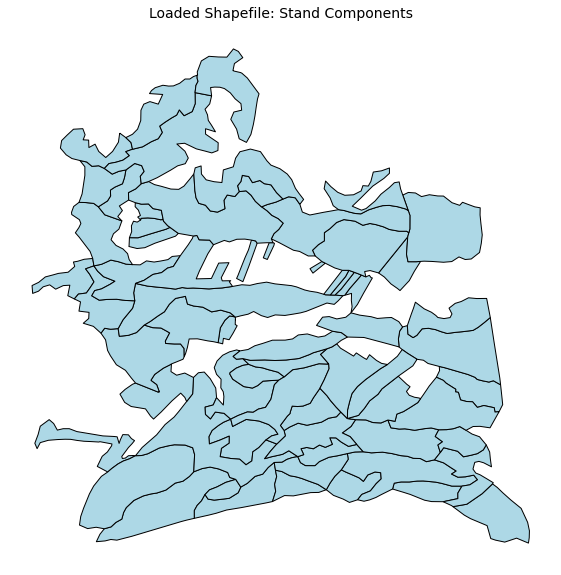

In [83]:
# Get the last part of the path
shp_name = os.path.basename(component_dir) + '.shp'

# Construct the full path in the target folder
target_folder = r'1_Preprocessed_Data\3_Stand_Components\3_merged_components'
shp_path = os.path.join(target_folder, shp_name)

# Load the shapefile
gdf = gpd.read_file(shp_path)

# Basic plot
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color='lightblue', edgecolor='black')

# Optional: add title
ax.set_title("Loaded Shapefile: Stand Components", fontsize=14)

# Hide axes if desired
ax.set_axis_off()

plt.show()

### plot shapefile

In [84]:
# Get the last part of the path
shp_name = os.path.basename(component_dir) + '.shp'

# Construct the full path in the target folder
target_folder = r'1_Preprocessed_Data\4_Road_Network_Graphs\comp_4_11_12_13_51_merged'
shp_path = os.path.join(target_folder, shp_name)

# Load the shapefile
gdf = gpd.read_file(shp_path)

# Basic plot
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color='lightblue', edgecolor='black')

# Optional: add title
ax.set_title("Loaded Shapefile: Stand Components", fontsize=14)

# Hide axes if desired
ax.set_axis_off()

plt.show()

DriverError: 1_Preprocessed_Data\4_Road_Network_Graphs\comp_4_11_12_13_51_merged\comp_4_11_12_13_51_merged.shp: No such file or directory

### plot the real edges

### plot the solution